<a href="https://colab.research.google.com/github/daniel-muthukrishna/transomaly/blob/master/anomaly_detection_probabilistic_mcdropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
! pip install astrorapid
! pip install celerite
! pip install keras-tcn
# ! pip install tensorflow-gpu

In [3]:
% cd /content/gdrive/My Drive/Projects/transomaly

/content/gdrive/My Drive/Projects/transomaly


In [4]:
import os
import numpy as np
import h5py
import pickle
import copy

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Masking, Input, Dropout

import tensorflow_probability as tfp
tfd = tfp.distributions

from tcn import TCN, tcn_full_summary
# from bayesian_tcn import TCN, tcn_full_summary

import astrorapid

from transomaly.prepare_training_set import PrepareTrainingSetArrays
from transomaly.loss_functions import mean_squared_error, chisquare_loss, mean_squared_error_over_error, negloglike, negloglike_with_error
from transomaly.plot_metrics import plot_history  # , plot_metrics

You will need to install 'emcee' if you wish to train your own classifier on new data.


Using TensorFlow backend.


In [5]:
COLPB = {'g': 'tab:blue', 'r': 'tab:red', 'gpred': 'turquoise', 'rpred': 'tab:pink'}
MARKPB = {'g': 'o', 'r': 's', 'z': 'd'}
ALPHAPB = {'g': 0.3, 'r': 1., 'z': 1}
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
from astropy.stats import median_absolute_deviation

from transomaly.fit_gaussian_processes import save_gps
from astrorapid.get_training_data import get_data
from transomaly import helpers

def plot_history(history, model_filename):
    # Plot loss vs epochs
    plt.figure()
    trainloss = history.history['loss']
    valloss = history.history['val_loss']
    plt.plot(trainloss)
    plt.plot(valloss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(model_filename.replace('.hdf5', '.pdf'))
    #Plot zoomed y axis figure
    plt.figure()
    plt.plot(trainloss)
    plt.plot(valloss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.ylim(bottom=min(valloss)-abs(0.1*min(valloss)), top=1.1*max(np.array(valloss)[abs(valloss-np.median(valloss)) < 5 * median_absolute_deviation(valloss)]))
    plt.savefig(f"{model_filename.replace('.hdf5', '_zoomed0.pdf')}")
    # Plot zoomed figure
    lenloss = len(trainloss)
    zoomloss = int(lenloss / 2.)
    plt.figure()
    plt.plot(np.arange(zoomloss, lenloss), trainloss[zoomloss:])
    plt.plot(np.arange(zoomloss, lenloss), valloss[zoomloss:])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.ylim(bottom=min(valloss)-abs(0.1*min(valloss)), top=1.1*max(np.array(valloss[zoomloss:])[abs(valloss[zoomloss:]-np.median(valloss[zoomloss:])) < 5 * median_absolute_deviation(valloss[zoomloss:])]))
    plt.savefig(f"{model_filename.replace('.hdf5', '_zoomed.pdf')}")
    # Plot zoomed figure reduced y axis
    lenloss = len(trainloss)
    zoomloss = int(0.75*lenloss)
    plt.figure()
    plt.plot(np.arange(zoomloss, lenloss), trainloss[zoomloss:])
    plt.plot(np.arange(zoomloss, lenloss), valloss[zoomloss:])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.ylim(bottom=min(valloss)-abs(0.1*min(valloss)), top=1.1*max(np.array(valloss[zoomloss:])[abs(valloss[zoomloss:]-np.median(valloss[zoomloss:])) < 5 * median_absolute_deviation(valloss[zoomloss:])]))
    plt.savefig(f"{model_filename.replace('.hdf5', '_zoomed2.pdf')}")


def plot_metrics(model, model_name, X_test, y_test, timesX_test, yerr_test, labels_test, objids_test, passbands, fig_dir, nsamples, data_dir,  save_dir, nprocesses, plot_gp=False, extrapolate_gp=True, reframe=False, plot_name='', npred=49, probabilistic=False, known_redshift=False, get_data_func=None, normalise=False, bayesian=False, model_num=None):
    print(model_name)
    nobjects, ntimesteps, nfeatures = X_test.shape
    npassbands = len(passbands)
    sntypes_map = helpers.get_sntypes()

    sampled_ypred = []
    sampled_ystd = []
    draws = []
    if probabilistic:
        X_test = np.asarray(X_test, np.float32)
        y_test = np.asarray(y_test, np.float32)
        # yhat = model(X_test)
        # y_pred = np.asarray(yhat.mean())
        # y_pred_std = np.asarray(yhat.stddev())
        if bayesian:
            ns = 100
            for i in range(ns):
                sampled_yhat = model(X_test)
                sampled_ypred.append(np.asarray(sampled_yhat.mean()))
                sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
                draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
            # plot_mean_ypred = np.mean(np.array(sampled_ypred), axis=0)
            # plot_sigma_ypred = np.std(np.array(sampled_ypred), axis=0)
            plot_mean_ypred = np.mean(np.array(draws), axis=0)
            plot_sigma_ypred = 0.2*np.std(np.array(draws), axis=0)
        else:
            yhat = model(X_test)
            plot_mean_ypred = np.asarray(yhat.mean())
            plot_sigma_ypred = np.asarray(yhat.stddev())
    else:
        y_pred = model.predict(X_test)

    if not reframe:
        npred = ntimesteps

    # Get raw light curve data
    light_curves = {}
    gp_fits = {}
    for classnum in np.unique(labels_test):
        print(f"Getting lightcurves for class:{classnum}")
        light_curves[classnum] = get_data(get_data_func=get_data_func, class_num=classnum, data_dir=data_dir,
                                          save_dir=save_dir, passbands=passbands, known_redshift=known_redshift,
                                          nprocesses=nprocesses, redo=False, calculate_t0=False)
        if plot_gp is True and nsamples == 1:
            gp_fits[classnum] = save_gps(light_curves, save_dir, classnum, passbands, plot=False,
                                     nprocesses=nprocesses, redo=False, extrapolate=extrapolate_gp)

    # # Plot predictions vs time per class
    # font = {'family': 'normal',
    #         'size': 36}
    # matplotlib.rc('font', **font)

    # # Example transients for paper
    # # import pdb; pdb.set_trace()
    # ylims_paper_objids = {'1_132490785': (-300, 2400), '2_113673268': (-350, 1100), '3_125078236': (-600, 1700), '51_107222452': (-350, 1200), '60_39476620': (-400, 2400), '64_31366754': (-150, 800)}  # '51_107222452': (-3, 1200)
    # for paper_objid in ['1_132490785', '2_113673268', '3_125078236', '51_107222452', '60_39476620', '64_31366754']:
    #     try:
    #         paper_idx = int(np.where(objids_test == paper_objid)[0])
    #     except TypeError:
    #         continue
    #     print(paper_idx, paper_objid)
    #     cnum = int(paper_objid.split('_')[0])
    #     cname = sntypes_map[cnum]
    #     lc = light_curves[cnum][paper_objid]

    #     # fig, (ax1) = plt.subplots(nrows=1, ncols=1) #1
    #     fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5.2, 6), sharex=True) #2
    #     for pbidx, pb in enumerate(passbands):
    #         pbmask = lc['passband'] == pb
    #         ax1.errorbar(lc[pbmask]['time'].data, lc[pbmask]['flux'].data, yerr=lc[pbmask]['fluxErr'].data, fmt='.', color=COLPB[pb], label=f'${pb}$-band obs')
    #         # ax1.errorbar(timesX_test[paper_idx][1:][-npred:], y_test[paper_idx][:, pbidx], yerr=yerr_test[paper_idx][:, pbidx], label=f'${pb}$ band interp data', fmt='.', linestyle='-', color='cyan')
    #         for drawidx in range(ns):
    #             ax1.plot(timesX_test[paper_idx][1:][-npred:], sampled_ypred[drawidx][paper_idx][:, pbidx], color=COLPB[pb], alpha=0.05)
    #         ax1.plot(timesX_test[paper_idx][1:][-npred:], np.median(np.array(sampled_ypred)[:, paper_idx, :, pbidx], axis=0), label=f'${pb}$-band pred', color=COLPB[pb], linewidth=2, linestyle='-')  # median
    #         # ax1.errorbar(timesX_test[paper_idx][1:][-npred:], plot_mean_ypred[paper_idx][:, pbidx], yerr=plot_sigma_ypred[paper_idx][:, pbidx], color='pink', label=f'${pb}$ band pred mean')
    #     ax1.tick_params(axis='x', labelsize=15)
    #     ax1.tick_params(axis='y', labelsize=15)
    #     ax2.tick_params(axis='x', labelsize=15) #2
    #     ax2.tick_params(axis='y', labelsize=15) #2
    #     plt.xlim(max(-67, min(lc[pbmask]['time'].data)), min(77, max(timesX_test[paper_idx][1:][-npred:])))
    #     ax1.set_ylim(*ylims_paper_objids[paper_objid])
    #     chi2 = 0
    #     negloglike = 0
    #     maskzeros = True
    #     maskzeros_pb = {}
    #     mask_npb = 0
    #     for pbidx in range(npassbands):
    #         yt = y_test[paper_idx, :, pbidx]
    #         yterr = yerr_test[paper_idx, :, pbidx]
    #         yp = plot_mean_ypred[paper_idx, :, pbidx]
    #         yperr = plot_sigma_ypred[paper_idx, :, pbidx]
    #         maskzeros_pb[pb] = ((yterr != 0) * (np.isfinite(yterr)))
    #         mask_npb = maskzeros_pb[pb] + mask_npb
    #         maskzeros = maskzeros_pb[pb] & maskzeros
    #         chi2_pb = ((yp - yt)/yterr)**2
    #         chi2_pb[~np.isfinite(chi2_pb)] = 0
    #         chi2 += chi2_pb
    #         negloglike_pb = 0.5 * (yp - yt)**2 / (yterr**2 + yperr**2) + 0.5 *np.log(yterr**2 + yperr**2) + 0.5*np.log(2*np.pi)
    #         negloglike_pb[~np.isfinite(negloglike_pb)] = 0
    #         negloglike += negloglike_pb
    #     chi2 = chi2 / mask_npb
    #     chi2cumsum = np.cumsum(chi2)/np.arange(1, len(chi2)+1)
    #     negloglike = negloglike / mask_npb
    #     negloglikecumsum = np.cumsum(negloglike)/np.arange(1, len(negloglike)+1)
    #     # ax1.text(0.05, 0.95, f"$\chi^2 = {round(max(chi2), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure) #1
    #     # ax1.text(0.05, 0.95, f"{class_name}", transform=fig.transFigure) #1
    #     ax1.set_ylabel("Relative flux", fontsize=15)
    #     # ax1.set_xlabel("Time since trigger [days]", fontsize=15) #1
    #     ax2.set_xlabel("Time since trigger [days]", fontsize=15) #2
    #     ax2.set_ylabel("Anomaly score", fontsize=15) #2
    #     # ax1.legend(frameon=True, fontsize=13, loc='upper left')
    #     ax2.plot(timesX_test[paper_idx][1:][-npred:], negloglikecumsum, lw=2) #2
    #     # ax2.text(0.05, 0.95, f"$\chi^2 = {round(np.sum(chi2)/len(yt), 3)}$", horizontalalignment='left', verticalalignment='center', transform=ax2.transAxes) #2
    #     plt.tight_layout()
    #     fig.subplots_adjust(hspace=0) #2
    #     # plt.savefig(f"DNN_model-{classnum}_fitting-{paper_objid}_scaleyperrby0point2.png") #1
    #     plt.savefig(f"DNN_model-{model_num}_fitting-{paper_objid}_withanomalyplot_scaleyperrby0point2.pdf") #2
    #     plt.show()
    #     plt.close()

    #Plot example lightcurves and anomaly scores
    for idx in np.arange(0, 10):
        sidx = idx * nsamples  # Assumes like samples are in order
        print("Plotting example vs time", idx, objids_test[sidx])
        argmax = None  #timesX_test[sidx].argmax()  # -1

        # Get raw light curve observations
        lc = light_curves[labels_test[sidx]][objids_test[sidx]]
        if plot_gp is True and nsamples == 1:
            gp_lc = gp_fits[labels_test[sidx]][objids_test[sidx]]

        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5.2, 6), sharex=True)

        for pbidx, pb in enumerate(passbands):
            pbmask = lc['passband'] == pb

            for s in range(1):#nsamples):
                lw = 1 if s == 0 else 0.1
                alpha = 1 if s == 0 else 0.1
                plotlabeltest = "ytest:{}".format(pb) if s == 0 else ''
                plotlabelpred = "ypred:{}".format(pb) if s == 0 else ''
                marker = None  # MARKPB[pb] if s == 0 else None
                if reframe:
                    ax1.plot(timesX_test[sidx + s][:-1][:argmax], X_test[sidx + s][:, pbidx][:-1][:argmax], c=COLPB[pb], lw=lw,
                             label=plotlabeltest, marker=marker, markersize=3, alpha=alpha, linestyle='-')
                ax1.errorbar(timesX_test[sidx+s][1:][-npred:][:argmax], y_test[sidx+s][:, pbidx][:argmax], yerr=yerr_test[sidx+s][:, pbidx][:argmax], c=COLPB[pb], lw=lw,
                         label=plotlabeltest, marker='o', markersize=3, alpha=alpha, linestyle='-')
                if probabilistic:
                    if bayesian:
                        for sp in range(ns):
                            ax1.errorbar(timesX_test[sidx + s][1:][-npred:][:argmax], sampled_ypred[sp][sidx + s][:, pbidx][:argmax], yerr=sampled_ystd[sp][sidx + s][:, pbidx][:argmax],
                                    color=COLPB[f'{pb}pred'], lw=0.1, marker='*', markersize=3, alpha=1/256, linestyle=':')
                    ax1.errorbar(timesX_test[sidx + s][1:][-npred:][:argmax], plot_mean_ypred[sidx + s][:, pbidx][:argmax], yerr=plot_sigma_ypred[sidx + s][:, pbidx][:argmax],
                            color=COLPB[f'{pb}pred'], lw=lw, label=plotlabelpred, marker='x', markersize=5, alpha=1, linestyle=':')
  
                else:
                    ax1.plot(timesX_test[sidx+s][1:][-npred:][:argmax], y_pred[sidx+s][:, pbidx][:argmax], c=COLPB[f'{pb}pred'], lw=lw,
                             label=plotlabelpred, marker='*', markersize=3, alpha=alpha, linestyle=':')

            if not normalise:
                ax1.errorbar(lc[pbmask]['time'].data, lc[pbmask]['flux'].data, yerr=lc[pbmask]['fluxErr'].data,
                            fmt="x", capsize=0, color=COLPB[pb], label='_nolegend_', markersize=3, )

                if plot_gp is True and nsamples == 1:
                    gp_lc[pb].compute(lc[pbmask]['time'].data, lc[pbmask]['fluxErr'].data)
                    pred_mean, pred_var = gp_lc[pb].predict(lc[pbmask]['flux'].data, timesX_test[sidx + s][:argmax],
                                                            return_var=True)
                    pred_std = np.sqrt(pred_var)
                    ax1.fill_between(timesX_test[sidx + s][:argmax], pred_mean + pred_std, pred_mean - pred_std, color=COLPB[pb],
                                    alpha=0.05,
                                    edgecolor="none")
                # ax1.text(0.05, 0.95, f"$\chi^2 = {round(save_chi2[objids_test[idx]], 3)}$", horizontalalignment='left',
                #          verticalalignment='center', transform=ax1.transAxes)
                # plt.xlim(-70, 80)

        # Plot anomaly scores
        chi2_samples = []
        like_samples = []
        negloglike_samples = []
        for s in range(1):#nsamples):
            chi2 = 0
            like = 0
            negloglike = 0
            for pbidx in range(npassbands):
                m = yerr_test[sidx+s, :, pbidx][:argmax] != 0  # ignore zeros (where no data exists)
                yt = y_test[sidx+s, :, pbidx][:argmax][m]
                yterr = yerr_test[sidx+s, :, pbidx][:argmax][m]
                yp = plot_mean_ypred[sidx+s, :, pbidx][:argmax][m]
                yperr = plot_sigma_ypred[sidx+s, :, pbidx][:argmax][m]
                try:
                    chi2 += ((yp - yt)/yterr)**2
                    like += np.exp(-0.5*(yp-yt)**2 / (yterr**2+yperr**2)) * (2*np.pi*(yterr**2+yperr**2))**-0.5
                    negloglike += -(-0.5 * (yt - yp)**2 / (yterr**2 + yperr**2) - 0.5 *np.log(yterr**2 + yperr**2) - 0.5*np.log(2*np.pi))
                except ValueError as e:
                    pbidx -= 1
                    m = yerr_test[sidx + s, :, pbidx][:argmax] != 0
                    print(f"Failed chi2 object {objids_test[sidx+s]}", e)
            chi2cumsum = np.cumsum(chi2)/np.arange(1, len(chi2)+1)
            chi2_samples.append(chi2cumsum / npassbands)
            like_samples.append(like/npassbands)
            negloglike_samples.append(negloglike/npassbands)
        anomaly_score_samples = chi2_samples
        anomaly_score_mean = np.mean(anomaly_score_samples, axis=0)
        anomaly_score_std = np.std(anomaly_score_samples, axis=0)
        ax2.text(0.05, 0.95, f"$\chi^2 = {round(np.sum(np.mean(chi2_samples, axis=0))/len(yt), 3)}$", horizontalalignment='left',
                 verticalalignment='center', transform=ax2.transAxes)
        ax2.text(0.05, 0.75, f"$likelihood = {round(np.sum(like_samples)/len(yt), 3)}$", horizontalalignment='left',
          verticalalignment='center', transform=ax2.transAxes)
        ax2.text(0.05, 0.55, f"$negloglike = {round(np.sum(np.mean(negloglike_samples, axis=0))/len(yt), 3)}$", horizontalalignment='left',
          verticalalignment='center', transform=ax2.transAxes)

        ax2.plot(timesX_test[sidx][1:][-npred:][:argmax][m], anomaly_score_mean, lw=1, marker='o', markersize=3)
        ax2.fill_between(timesX_test[sidx][1:][-npred:][:argmax][m], anomaly_score_mean + anomaly_score_std, anomaly_score_mean - anomaly_score_std, alpha=0.3, edgecolor="none")

        ax1.legend(frameon=True)
        ax1.set_ylabel("Relative flux")
        ax2.set_ylabel("Anomaly score")
        ax2.set_xlabel("Time since trigger [days]")
        plt.tight_layout()
        fig.subplots_adjust(hspace=0)
        plt.savefig(os.path.join(fig_dir, model_name, f"lc_{objids_test[sidx]}_{idx}{plot_name}.pdf"))
        plt.close()

    print(model_name)
    # print(f"Reduced chi-squared for model is {chi2_reduced_allobjects}")
    # print(f"Median reduced chi-squared for model is {np.median(chi2_hist)}")


In [6]:
def build_model(X_train, passbands=('g', 'r'), reframe=False, probabilistic=False, nunits=100, bayesian=False, dropout_rate=0.0):
    if bayesian:
        mc_dropout = True
    else:
        mc_dropout = None
    npb = len(passbands)
    
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    hidden = Masking(mask_value=0.)(inputs)

    hidden = TCN(nunits, return_sequences=True, kernel_size=2, nb_stacks=1, dilations=[1, 2, 4, 8],
                  padding='causal', use_skip_connections=True, dropout_rate=dropout_rate, activation='sigmoid')(hidden, training=mc_dropout)
    # hidden = Dropout(dropout_rate)(hidden, training=mc_dropout)


    if reframe is True:
        hidden = LSTM(nunits)(hidden)
        hidden = Dense(npb)(hidden)
    else:
        if probabilistic:
            hidden = TimeDistributed(Dense(npb * 2))(hidden)
        else:
            hidden = TimeDistributed(Dense(npb * 1))(hidden)
    
    if probabilistic:
        outputs = tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(loc=t[..., :npb], scale=1e-3 + tf.math.softplus(0.01*t[..., npb:])))(hidden)
    else:
        outputs = hidden

    model = Model(inputs, outputs)

    return model


def train_model(X_train, X_test, y_train, y_test, yerr_train, yerr_test, fig_dir='.', epochs=20, retrain=False,
                passbands=('g', 'r'), model_change='', reframe=False, probabilistic=False, train_from_last_stop=0,
                batch_size=50, nunits=100, use_uncertainties=False, bayesian=False, dropout_rate=0.0, learning_rate=0.001):

    model_name = f"keras_model_epochs{epochs+train_from_last_stop}_{model_change}"
    model_filename = os.path.join(fig_dir, model_name, f"{model_name}.hdf5")
    if not os.path.exists(os.path.join(fig_dir, model_name)):
        os.makedirs(os.path.join(fig_dir, model_name))

    if probabilistic:
        if use_uncertainties:
            lossfn = negloglike_with_error()
        else:
            lossfn = negloglike()
    elif 'chi2' in model_change:
        lossfn = chisquare_loss()
    elif 'mse_oe' in model_change:
        lossfn = mean_squared_error_over_error()
    else:
        lossfn = mean_squared_error()

    if not retrain and os.path.isfile(model_filename):
        model = load_model(model_filename, custom_objects={'loss': lossfn, 'TCN': TCN})
    else:
        if train_from_last_stop:
            old_model_name = f"keras_model_epochs{train_from_last_stop}_{model_change}"
            old_model_filename = os.path.join(fig_dir, old_model_name, f"{old_model_name}.hdf5")
            model = load_model(model_filename, custom_objects={'loss': lossfn, 'TCN': TCN})
            history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,
                                batch_size=batch_size, verbose=2, inital_epoch=train_from_last_stop)
        else:
            model = build_model(X_train, passbands, reframe, probabilistic, nunits, bayesian, dropout_rate=dropout_rate)
            model.compile(loss=lossfn, optimizer=tf.optimizers.Adam(learning_rate=learning_rate))
            # tcn_full_summary(model, expand_residual_blocks=True)
            history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2)

        print(model.summary())
        model.save(model_filename)

        plot_history(history, model_filename)

    return model, model_name

In [7]:
font = {'family': 'normal',
        'size': 12}
matplotlib.rc('font', **font)

In [8]:
# Ignore objects that the Bazin function couldn't fit
class_nums_all = [1, 2, 3, 51, 60, 64]
objids_to_use = {class_num: [] for class_num in class_nums_all}
for class_num in class_nums_all:
    with open(f'save_bazin_params_class_multipb_{class_num}_041020_nopriors_resetx0_allobjects_usingonlygoodobjects.pickle', 'rb') as f:  # save_bazin_params_class_multipb_{class_num}.pickle
        load_bazin_params = pickle.load(f)
        objids_g = list(load_bazin_params['g'].keys())
        objids_r = list(load_bazin_params['r'].keys())
        objids_to_use[class_num] += objids_g + list(set(objids_r) - set(objids_g))

In [9]:
for class_num in class_nums_all:    
    print(class_num)
    class_nums = (class_num,)
    for npred in range(1, 2):
        SCRIPT_DIR = 'transomaly/'  # os.path.dirname(os.path.abspath(__file__))
        data_dir = os.path.join(SCRIPT_DIR, '..', 'data/ZTF_20190512')
        save_dir = os.path.join(SCRIPT_DIR, '..', 'data/saved_light_curves')
        training_set_dir = os.path.join(SCRIPT_DIR, '..', 'data/training_set_files')
        get_data_func = astrorapid.get_training_data.get_data_from_snana_fits
        fig_dir = os.path.join(SCRIPT_DIR, '..', 'plots')
        passbands = ('g', 'r')
        contextual_info = ()
        known_redshift = True if 'redshift' in contextual_info else False
        nprocesses = None
        # class_nums = (1,)
        otherchange = 'linear_spline_with_unc_inXandy'  #'using_only_goodobjectsw20datapoints'  # single_object_1_50075859'
        use_gp_interp = False
        nsamples = 1
        extrapolate_gp = False
        redo = False
        train_epochs = 10000
        learning_rate = 0.001
        retrain = False
        reframe_problem = False
        # npred = 1
        probabilistic = True
        batch_size = 64
        nunits = 30
        train_from_last_stop = 0
        normalise = False
        use_uncertainties = True
        bayesian = False
        dropout_rate = 0.2

        # nn_architecture_change = 'norm_onepointpred{}timestepsinfuture_steps{}normalised_{}negloglike_predict_last{}_timesteps_nodropout_100lstmneurons'.format(npred,'probabilistic_' if probabilistic else '', 'reframe_Xy_' if reframe_problem else '', npred)  # 'normalise_mse_withmasking_1000lstmneurons'  # 'chi2'  # 'mse'
        nn_architecture_change = f"mcdropout_TCN_{'probabilistic_' if probabilistic else ''}bayesian{bayesian}_uncertainties{use_uncertainties}_predictfuture{npred}point_normalised{normalise}_dropout{dropout_rate}_units{nunits}_batchsize{batch_size}_lr{learning_rate}"

        fig_dir = os.path.join(fig_dir, "model_{}_ci{}_ns{}_c{}".format(otherchange, contextual_info, nsamples, class_nums))
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)

        preparearrays = PrepareTrainingSetArrays(passbands, contextual_info, data_dir, save_dir, training_set_dir, redo, get_data_func, use_gp_interp)
        X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
        timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
            preparearrays.make_training_set(class_nums, nsamples, otherchange, nprocesses, extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties, only_use_objids=objids_to_use[class_num])

        model, model_name = train_model(X_train, X_test, y_train, y_test, yerr_train, yerr_test, fig_dir=fig_dir, epochs=train_epochs,
                            retrain=retrain, passbands=passbands, model_change=nn_architecture_change, reframe=reframe_problem, probabilistic=probabilistic, train_from_last_stop=train_from_last_stop, batch_size=batch_size, nunits=nunits, use_uncertainties=use_uncertainties, bayesian=bayesian, dropout_rate=dropout_rate, learning_rate=learning_rate)

        # try:
        #     plot_metrics(model, model_name, X_test, y_test, timesX_test, yerr_test, labels_test, objids_test, passbands=passbands,
        #                  fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=use_gp_interp, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian, model_num=class_num)
        
        #     # plot_metrics(model, model_name, X_train, y_train, timesX_train, yerr_train, labels_train, objids_train, passbands=passbands,
        #     #         fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=use_gp_interp, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='_training_set', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian, model_num=class_num)
        # except Exception as e:
        #     print(e)

        # Test on other classes  #51,60,62,70 AndOtherTypes
        # X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
        # timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
        #     preparearrays.make_training_set(class_nums=(51, 62, 63, 90, 92), nsamples=1, otherchange='kn_anomalies_test', nprocesses=nprocesses, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties, train_size=0.99)
        # plot_metrics(model, model_name, X_train, y_train, timesX_train, yerr_train, labels_train, objids_train, passbands=passbands,
        #             fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=use_gp_interp, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='anomaly', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian, model_num=class_num)
        # plt.show()



1
2
3
51
60
64


In [10]:
# print(np.where(objids_test=='64_44565071'))
# for i in range(49):
#     print(f"{timesX_test[3][i]}, ** {X_test[3][i]}, ** {y_test[3][i]}, ** {labels_test[3]}, ** {objids_test[3]}")
# np.where(np.all(X_test[:,3] == [0,0,0,0], axis=1))
# X_test[5]

In [11]:
#@title Analyse predictive uncertainties
nobjects, ntimesteps, nfeatures = y_test.shape
npassbands = len(passbands)
sntypes_map = helpers.get_sntypes()

if bayesian:
    sampled_ypred = []
    sampled_ystd = []
    draws = []
    ns = 100
    for i in range(ns):
        sampled_yhat = model(X_test)
        sampled_ypred.append(np.asarray(sampled_yhat.mean()))
        sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
        draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
    plot_mean_ypred = np.mean(np.array(draws), axis=0)
    plot_sigma_ypred = np.std(np.array(draws), axis=0)
else:
    yhat = model(X_test)
    plot_mean_ypred = np.asarray(yhat.mean())
    plot_sigma_ypred = np.asarray(yhat.stddev())

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Measured, predicted shapes: (2082, 49, 4) (2082, 49, 2) (2082, 49, 2)
pb: g, tstep: 0, Mean: -0.010731694257131998, std: 0.9476608848852379
pb: g, tstep: 1, Mean: 0.16158566649822612, std: 0.9678733184653778
pb: g, tstep: 2, Mean: 0.17450914750362925, std: 0.9343758892983542
pb: g, tstep: 3, Mean: 0.2464728622315568, std: 0.9283085285897946
pb: g, tstep: 4, Mean: 0.2904174231285224, std: 0.9003738324278587
pb: g, tstep: 5, Mean: 0.25640177801881653, std: 0.8827333072594328
pb: g, tstep: 6, Mean: 0.23557443754879145, std: 0.8961644754188398
pb: g, tstep: 7, Mean: 0.2203044915618558, std: 0.8916291620848097
pb: g, tstep: 8, Mean: 0.18175961643608174, std: 0.9097720872103321
pb: g, tstep: 9, Mean: 0.1522753140605161, std: 0.8869260249880028
pb: g, tstep: 10, Mean: 0.11809800549299, std: 0.8987681101848496
pb: g, tstep: 11, Mean: 0.0054948527332880255, std: 1.441073648760881
pb: g, tstep: 12, Mean: -0.06011684628333412, std: 0.9839975589140859
pb: g, tstep: 13, Mean: -0.12658651148760236, 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan


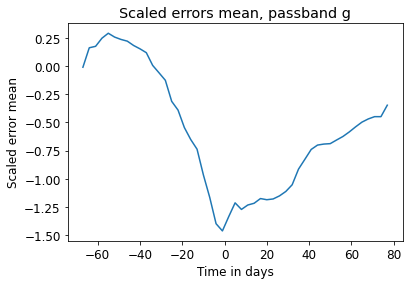

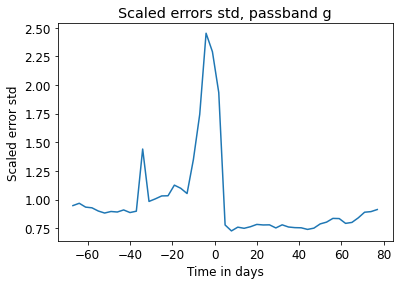

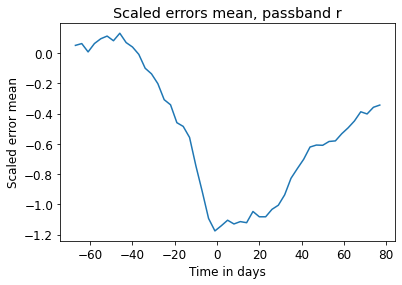

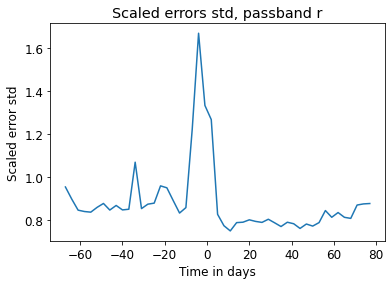

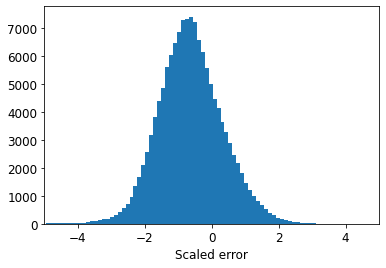

In [12]:
#@title Analyse predictive uncertainties continued...
import imageio
print("Measured, predicted shapes:", y_test.shape, plot_mean_ypred.shape, plot_sigma_ypred.shape)

maskzeros = (y_test[:,:,2:] == 0)
scaled_error = (plot_mean_ypred - y_test[:,:,:2])/np.sqrt(plot_sigma_ypred**2 + y_test[:,:,2:]**2)
scaled_error[maskzeros] = None
plot_times = np.arange(-67, 80, 3)
mean_scalederrors = {'g': [], 'r': []}
std_scalederrors = {'g': [], 'r': []}
for pbidx, pb in enumerate(passbands):
    images = []
    for tstep, t in enumerate(plot_times):
        tstep_mask = (np.abs(timesX_test[:,1:] - t)) < 1.5  # Mask time steps closest to t. No more than one index per object
        x = scaled_error[:,:,pbidx][tstep_mask]
        xmean = np.nanmean(x)
        xstd = np.nanstd(x)
        # plt.figure()
        # plt.title(f"DNN scaled errors pb: {pb} tstep: {tstep}, mean: {round(xmean,3)}, std: {round(xstd,3)}")
        # plt.hist(x, bins=100)
        # plt.xlim(-5,5)
        # plt.xlabel("Scaled error")
        # filename = f"DNN_scaled_errors_{pb}_{tstep}.png"
        # plt.savefig(filename)
        # plt.show()
        print(f"pb: {pb}, tstep: {tstep}, Mean: {xmean}, std: {xstd}")
        mean_scalederrors[pb].append(xmean)
        std_scalederrors[pb].append(xstd)
        # images.append(imageio.imread(filename))
    # imageio.mimsave(f'DNN_scaled_errors_{pb}.gif', images)
    plt.figure()
    plt.title(f"Scaled errors mean, passband {pb}")
    plt.plot(plot_times, mean_scalederrors[pb])
    plt.xlabel("Time in days")
    plt.ylabel("Scaled error mean")
    plt.savefig(f"DNN Scaled errors mean, passband {pb}.pdf")
    plt.figure()
    plt.title(f"Scaled errors std, passband {pb}")
    plt.plot(plot_times, std_scalederrors[pb])
    plt.xlabel("Time in days")
    plt.ylabel("Scaled error std")
    plt.savefig(f"DNN Scaled errors std, passband {pb}.pdf")


print("Scaled_error shape:", scaled_error.shape, scaled_error.flatten().shape)
plt.figure()
plt.hist(scaled_error.flatten(), bins=500);
plt.xlim(-5,5)
plt.xlabel("Scaled error")
plt.savefig(f"DNN Scaled errors all.pdf")
print(f"Mean: {np.mean(scaled_error.flatten())}, std: {np.std(scaled_error.flatten())}")

In [13]:
# sandbox
print(timesX_train[:,1:])
# nearest_idx = 
tstep_mask = (np.abs(timesX_test[:,1:] - 0)) < 1.5
scaled_error[:,:,1].shape, timesX_test[:,1:].shape
scaled_error[:,:,1][tstep_mask]

# helpers.find_nearest(timesX_train[:,1:], plot_times[0])

[[-56.957901   -53.957901   -50.957901   ...  81.042099    84.042099
   87.042099  ]
 [-63.95819855 -60.95819855 -57.95819855 ...  74.04180145  77.04180145
   80.04180145]
 [-65.12719727 -62.12719727 -59.12719727 ...   0.           0.
    0.        ]
 ...
 [ -7.94480038  -4.94480038  -1.94480038 ... 130.05519962 133.05519962
  136.05519962]
 [-65.6835022  -62.6835022  -59.6835022  ...   0.           0.
    0.        ]
 [-94.79219818 -91.79219818 -88.79219818 ...   0.           0.
    0.        ]]


array([-1.62878686,         nan,         nan, ...,         nan,
               nan,         nan])

Measured, predicted shapes: (2319, 49, 4) (2319, 49, 2) (2319, 49, 2)
class: SNIa-norm, pb: g, tstep: 0, Mean: 0.14132413567279947, std: 1.0455938039549786
class: SNIa-norm, pb: g, tstep: 1, Mean: 0.21708989653130165, std: 1.0537222599955276
class: SNIa-norm, pb: g, tstep: 2, Mean: 0.19066748094100633, std: 0.9860137530889497
class: SNIa-norm, pb: g, tstep: 3, Mean: 0.24366541147415685, std: 0.9430123973891094
class: SNIa-norm, pb: g, tstep: 4, Mean: 0.19335317649116804, std: 0.943806926980212
class: SNIa-norm, pb: g, tstep: 5, Mean: 0.18963541694225916, std: 0.9288386586970663
class: SNIa-norm, pb: g, tstep: 6, Mean: 0.17233733046699343, std: 0.9462142333708556
class: SNIa-norm, pb: g, tstep: 7, Mean: 0.14713457697735713, std: 0.9357962485081324
class: SNIa-norm, pb: g, tstep: 8, Mean: 0.20164689392586813, std: 0.9386234282449863
class: SNIa-norm, pb: g, tstep: 9, Mean: 0.18012250584905637, std: 0.9457146669636272
class: SNIa-norm, pb: g, tstep: 10, Mean: 0.20808981995864118, std: 0.9

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
class: SNIa-norm, pb: r, tstep: 0, Mean: 0.0652114753033883, std: 1.0447954332334572
class: SNIa-norm, pb: r, tstep: 1, Mean: 0.2729118068971722, std: 0.9991528350209488
class: SNIa-norm, pb: r, tstep: 2, Mean: 0.29465440084861816, std: 0.9288977862949305
class: SNIa-norm, pb: r, tstep: 3, Mean: 0.34886746129171115, std: 0.931799117991775
class: SNIa-norm, pb: r, tstep: 4, Mean: 0.2861899904898853, std: 0.9242665155061524
class: SNIa-norm, pb: r, tstep: 5, Mean: 0.253089335681884, std: 0.945970631517642
class: SNIa-norm, pb: r, tstep: 6, Mean: 0.27744827730893096, std: 0.9252389862222441
class: SNIa-norm, pb: r, tstep: 7, Mean: 0.25018074634553866, std: 0.9132792272521294
class: SNIa-norm, pb: r, tstep: 8, Mean: 0.29430887479231166, std: 0.9062325969141839
class: SNIa-norm, pb: r, tstep: 9, Mean: 0.32174684690907285, std: 0.9170943747561432
class: SNIa-norm, pb: r, tstep: 10, Mean: 0.2922407899700076, std: 0.921447135441491
class: SNIa-norm, pb: r, tstep: 11, Mean: 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
Measured, predicted shapes: (2319, 49, 4) (2319, 49, 2) (2319, 49, 2)
class: SNIa-norm, pb: g, tstep: 0, Mean: 0.15904196215592534, std: 1.0379246262313737
class: SNIa-norm, pb: g, tstep: 1, Mean: 0.1464243943119074, std: 1.0539177710020393
class: SNIa-norm, pb: g, tstep: 2, Mean: 0.13161240788634734, std: 1.0031117013846835
class: SNIa-norm, pb: g, tstep: 3, Mean: 0.22867079161422516, std: 0.9789217978916024
class: SNIa-norm, pb: g, tstep: 4, Mean: 0.2252379939730638, std: 0.9841263964625758
class: SNIa-norm, pb: g, tstep: 5, Mean: 0.22187407804751144, std: 0.9367996969151299
class: SNIa-norm, pb: g, tstep: 6, Mean: 0.21751976178979857, std: 0.9636930969653347
class: SNIa-norm, pb: g, tstep: 7, Mean: 0.18223033433937022, std: 0.9682094571420274
class: SNIa-norm, pb: g, tstep: 8, Mean: 0.22839636090900117, std: 0.975678628179304
class: SNIa-norm, pb: g, tstep: 9, Mean: 0.21279561541703013, std: 0.9851172289911232
class: SNIa-norm, pb: g, tstep: 10, Mean: 0.228883575

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
class: SNIa-norm, pb: r, tstep: 0, Mean: 0.05742182527241027, std: 1.0415997169090854
class: SNIa-norm, pb: r, tstep: 1, Mean: 0.17589965670697613, std: 0.9550944321610965
class: SNIa-norm, pb: r, tstep: 2, Mean: 0.20820956477963914, std: 0.9379097969091365
class: SNIa-norm, pb: r, tstep: 3, Mean: 0.3003067171643101, std: 0.9174463523031277
class: SNIa-norm, pb: r, tstep: 4, Mean: 0.25265795595855967, std: 0.9001048399915073
class: SNIa-norm, pb: r, tstep: 5, Mean: 0.22720360493969416, std: 0.9364291666095138
class: SNIa-norm, pb: r, tstep: 6, Mean: 0.24768572851788617, std: 0.9163835346934628
class: SNIa-norm, pb: r, tstep: 7, Mean: 0.23364096719904515, std: 0.8962839658624373
class: SNIa-norm, pb: r, tstep: 8, Mean: 0.262663692653086, std: 0.8890586465131859
class: SNIa-norm, pb: r, tstep: 9, Mean: 0.28747765931589125, std: 0.8858482199383602
class: SNIa-norm, pb: r, tstep: 10, Mean: 0.27596889143582687, std: 0.8997136349346904
class: SNIa-norm, pb: r, tstep: 11, 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan


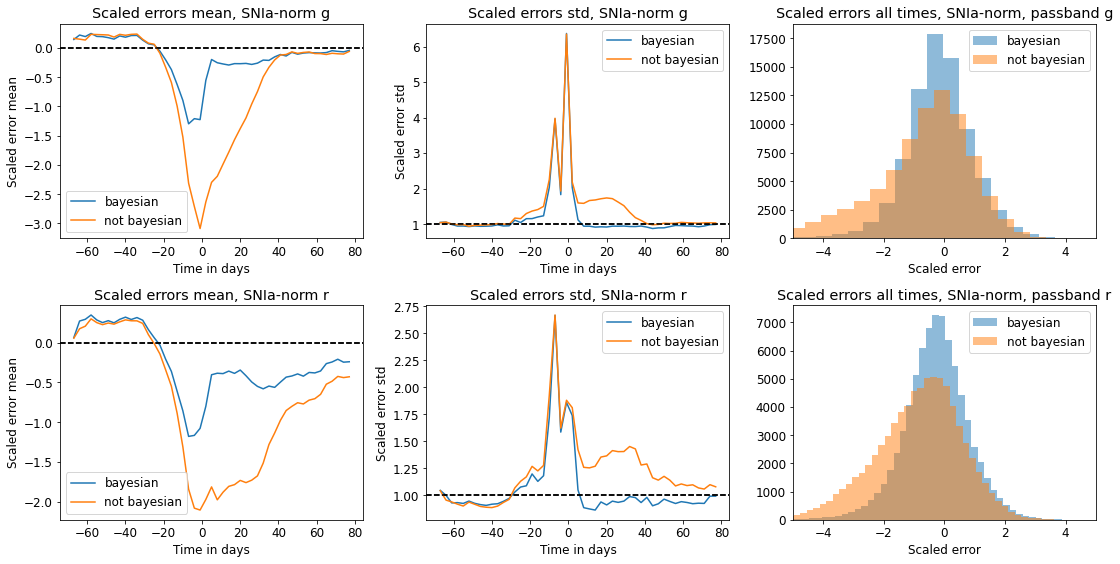

Measured, predicted shapes: (1970, 49, 4) (1970, 49, 2) (1970, 49, 2)
class: SNII, pb: g, tstep: 0, Mean: -0.018269274418762613, std: 1.0308103659657453
class: SNII, pb: g, tstep: 1, Mean: 0.08261604910498507, std: 0.963676895407708
class: SNII, pb: g, tstep: 2, Mean: 0.07661319920723816, std: 0.9024226434894463
class: SNII, pb: g, tstep: 3, Mean: 0.1616714757253573, std: 0.8800365098652939
class: SNII, pb: g, tstep: 4, Mean: 0.14176669074142517, std: 0.9003732998380455
class: SNII, pb: g, tstep: 5, Mean: 0.12383522304966467, std: 0.8448272293374018
class: SNII, pb: g, tstep: 6, Mean: 0.09724317438111425, std: 0.9215685941980513
class: SNII, pb: g, tstep: 7, Mean: 0.11760063076843852, std: 0.9194301000975157
class: SNII, pb: g, tstep: 8, Mean: 0.12416390774499983, std: 0.9410093427459336
class: SNII, pb: g, tstep: 9, Mean: 0.12083300293967918, std: 0.9097183351770314
class: SNII, pb: g, tstep: 10, Mean: 0.12086908839897924, std: 0.9230059296662508
class: SNII, pb: g, tstep: 11, Mean: 0

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
class: SNII, pb: r, tstep: 0, Mean: 0.10039330333100502, std: 1.0077755438050604
class: SNII, pb: r, tstep: 1, Mean: 0.160268914043891, std: 0.957542845212498
class: SNII, pb: r, tstep: 2, Mean: 0.1781557501544654, std: 0.9248436959874649
class: SNII, pb: r, tstep: 3, Mean: 0.2276066180303732, std: 0.8804076911412304
class: SNII, pb: r, tstep: 4, Mean: 0.30393478951057773, std: 0.9065367058777323
class: SNII, pb: r, tstep: 5, Mean: 0.2901099797673858, std: 0.8734938430918138
class: SNII, pb: r, tstep: 6, Mean: 0.262737324389897, std: 0.9232706197003163
class: SNII, pb: r, tstep: 7, Mean: 0.24589010573715328, std: 0.8718449449426139
class: SNII, pb: r, tstep: 8, Mean: 0.26723970220330123, std: 0.8507056748092313
class: SNII, pb: r, tstep: 9, Mean: 0.20539518911543683, std: 0.878369903996528
class: SNII, pb: r, tstep: 10, Mean: 0.20953439122660258, std: 0.9017884234120942
class: SNII, pb: r, tstep: 11, Mean: 0.23411765326219636, std: 0.9132956844062146
class: SNII, pb

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
Measured, predicted shapes: (1970, 49, 4) (1970, 49, 2) (1970, 49, 2)
class: SNII, pb: g, tstep: 0, Mean: -0.04810028017210714, std: 1.0027924119686848
class: SNII, pb: g, tstep: 1, Mean: 0.06826330360670856, std: 0.9548471205540529
class: SNII, pb: g, tstep: 2, Mean: 0.10114704135919637, std: 0.8995926863324321
class: SNII, pb: g, tstep: 3, Mean: 0.17024835379154818, std: 0.8705685774448011
class: SNII, pb: g, tstep: 4, Mean: 0.14451109310999868, std: 0.8891926216895062
class: SNII, pb: g, tstep: 5, Mean: 0.1474461072230818, std: 0.8417902331671058
class: SNII, pb: g, tstep: 6, Mean: 0.12230549875558204, std: 0.9152946866971583
class: SNII, pb: g, tstep: 7, Mean: 0.1560722476770896, std: 0.9045939837770948
class: SNII, pb: g, tstep: 8, Mean: 0.1695607039589392, std: 0.9279955420285501
class: SNII, pb: g, tstep: 9, Mean: 0.16231938717917846, std: 0.8968330778267705
class: SNII, pb: g, tstep: 10, Mean: 0.15714643886366347, std: 0.9121766034296103
class: SNII, pb: g, 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
class: SNII, pb: r, tstep: 0, Mean: 0.11284821177030889, std: 1.0103440420610637
class: SNII, pb: r, tstep: 1, Mean: 0.17691279719160644, std: 0.95544089726213
class: SNII, pb: r, tstep: 2, Mean: 0.1818079940190168, std: 0.9358230440732523
class: SNII, pb: r, tstep: 3, Mean: 0.20342183759510868, std: 0.8700873663789005
class: SNII, pb: r, tstep: 4, Mean: 0.25970156451098075, std: 0.9155178864864217
class: SNII, pb: r, tstep: 5, Mean: 0.2731694168372147, std: 0.8900776394648761
class: SNII, pb: r, tstep: 6, Mean: 0.24927658566499608, std: 0.9272301260854694
class: SNII, pb: r, tstep: 7, Mean: 0.26015815940041065, std: 0.88807260829679
class: SNII, pb: r, tstep: 8, Mean: 0.2795970822035139, std: 0.8740313076700712
class: SNII, pb: r, tstep: 9, Mean: 0.2133874427323027, std: 0.8893710326068985
class: SNII, pb: r, tstep: 10, Mean: 0.20814870842254488, std: 0.9302292697480318
class: SNII, pb: r, tstep: 11, Mean: 0.21495090328476105, std: 0.9533833750610449
class: SNII, p

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan


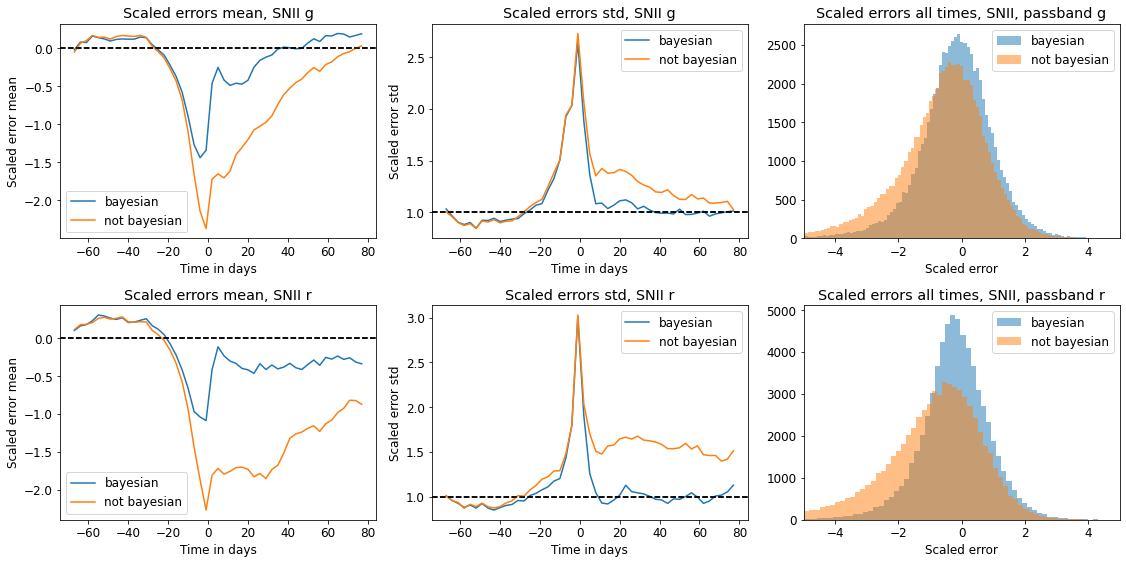

Measured, predicted shapes: (2058, 49, 4) (2058, 49, 2) (2058, 49, 2)
class: SNIbc, pb: g, tstep: 0, Mean: 0.08562435905452691, std: 1.010001713131812
class: SNIbc, pb: g, tstep: 1, Mean: 0.19855210072185844, std: 0.979949515841994
class: SNIbc, pb: g, tstep: 2, Mean: 0.21046111250009994, std: 0.9615806002324516
class: SNIbc, pb: g, tstep: 3, Mean: 0.20757033602773312, std: 0.9673172136065932
class: SNIbc, pb: g, tstep: 4, Mean: 0.28034575207161927, std: 0.9873059653052034
class: SNIbc, pb: g, tstep: 5, Mean: 0.2764869081968, std: 0.940805175727228
class: SNIbc, pb: g, tstep: 6, Mean: 0.2491748576932023, std: 0.9162664969430331
class: SNIbc, pb: g, tstep: 7, Mean: 0.22767135522141957, std: 0.942946198913318
class: SNIbc, pb: g, tstep: 8, Mean: 0.25137506371914825, std: 0.9310181133288112
class: SNIbc, pb: g, tstep: 9, Mean: 0.22901704861294658, std: 0.9013815518368421
class: SNIbc, pb: g, tstep: 10, Mean: 0.23522284690391523, std: 0.9344333952033796
class: SNIbc, pb: g, tstep: 11, Mean

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
class: SNIbc, pb: r, tstep: 0, Mean: -0.031323777549747515, std: 1.058756956338761
class: SNIbc, pb: r, tstep: 1, Mean: 0.02831782237031769, std: 0.9234631463386138
class: SNIbc, pb: r, tstep: 2, Mean: 0.10174420392992398, std: 0.8692140479801115
class: SNIbc, pb: r, tstep: 3, Mean: 0.13489145702701325, std: 0.8583698093726588
class: SNIbc, pb: r, tstep: 4, Mean: 0.1563390347304107, std: 0.8948936200407548
class: SNIbc, pb: r, tstep: 5, Mean: 0.18864691138598472, std: 0.896011366510982
class: SNIbc, pb: r, tstep: 6, Mean: 0.18261230698983566, std: 0.9033862629290329
class: SNIbc, pb: r, tstep: 7, Mean: 0.22652866749786077, std: 0.8685339987607283
class: SNIbc, pb: r, tstep: 8, Mean: 0.23108634777574943, std: 0.8485964681850496
class: SNIbc, pb: r, tstep: 9, Mean: 0.2545616004082945, std: 0.8640452990705221
class: SNIbc, pb: r, tstep: 10, Mean: 0.21968786613576166, std: 0.8862781002239561
class: SNIbc, pb: r, tstep: 11, Mean: 0.2068183567974285, std: 0.91613206122134

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
Measured, predicted shapes: (2058, 49, 4) (2058, 49, 2) (2058, 49, 2)
class: SNIbc, pb: g, tstep: 0, Mean: 0.03069439003235888, std: 1.0135978754390869
class: SNIbc, pb: g, tstep: 1, Mean: 0.0961893083306523, std: 0.9815051896617883
class: SNIbc, pb: g, tstep: 2, Mean: 0.16602067672806772, std: 0.9623482123972791
class: SNIbc, pb: g, tstep: 3, Mean: 0.16788442240195753, std: 0.9642049123354823
class: SNIbc, pb: g, tstep: 4, Mean: 0.21765657851841827, std: 0.9865097926938752
class: SNIbc, pb: g, tstep: 5, Mean: 0.2066430353535666, std: 0.9412021061468488
class: SNIbc, pb: g, tstep: 6, Mean: 0.17116223103489273, std: 0.9334558870235163
class: SNIbc, pb: g, tstep: 7, Mean: 0.14732730742966177, std: 0.9644748401765435
class: SNIbc, pb: g, tstep: 8, Mean: 0.17741957301768643, std: 0.9475090866321711
class: SNIbc, pb: g, tstep: 9, Mean: 0.1568484448860025, std: 0.9148832365094037
class: SNIbc, pb: g, tstep: 10, Mean: 0.1507742639098875, std: 0.9294647590830579
class: SNIb

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
class: SNIbc, pb: r, tstep: 0, Mean: 0.016020365570743936, std: 1.0581573319533673
class: SNIbc, pb: r, tstep: 1, Mean: 0.14583217654717118, std: 0.9426946386852036
class: SNIbc, pb: r, tstep: 2, Mean: 0.21328224268772772, std: 0.9156608581340931
class: SNIbc, pb: r, tstep: 3, Mean: 0.23456882108382024, std: 0.9015996815764697
class: SNIbc, pb: r, tstep: 4, Mean: 0.24494705848413753, std: 0.9205591711726796
class: SNIbc, pb: r, tstep: 5, Mean: 0.24761969345513854, std: 0.9221718269892591
class: SNIbc, pb: r, tstep: 6, Mean: 0.206969752548376, std: 0.9488696886059107
class: SNIbc, pb: r, tstep: 7, Mean: 0.2319142643121568, std: 0.905339998574919
class: SNIbc, pb: r, tstep: 8, Mean: 0.2299253896847953, std: 0.8829525432175093
class: SNIbc, pb: r, tstep: 9, Mean: 0.24682712227360268, std: 0.9005244178983887
class: SNIbc, pb: r, tstep: 10, Mean: 0.21124090103319126, std: 0.9053534651337807
class: SNIbc, pb: r, tstep: 11, Mean: 0.18618647634523933, std: 0.958692228019637

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan


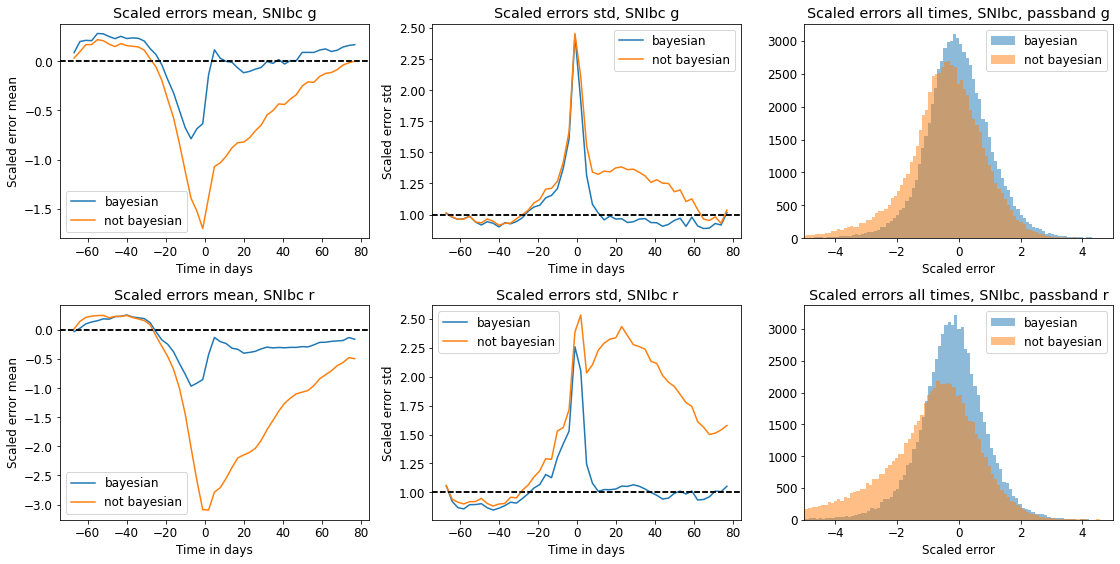

Measured, predicted shapes: (1879, 49, 4) (1879, 49, 2) (1879, 49, 2)
class: Kilonova, pb: g, tstep: 0, Mean: 0.06482711212766581, std: 1.0064310781238448
class: Kilonova, pb: g, tstep: 1, Mean: 0.29293296930840207, std: 0.9709951172186884
class: Kilonova, pb: g, tstep: 2, Mean: 0.30591128462174866, std: 0.9560078900363838
class: Kilonova, pb: g, tstep: 3, Mean: 0.22826109148000884, std: 0.9610976665703755
class: Kilonova, pb: g, tstep: 4, Mean: 0.1839306057887005, std: 0.9347897037127963
class: Kilonova, pb: g, tstep: 5, Mean: 0.2145168757549597, std: 0.9345727887018461
class: Kilonova, pb: g, tstep: 6, Mean: 0.25479635193628075, std: 0.922377386062158
class: Kilonova, pb: g, tstep: 7, Mean: 0.29756332025254106, std: 0.9223885644536262
class: Kilonova, pb: g, tstep: 8, Mean: 0.269379047054779, std: 0.8969504466575766
class: Kilonova, pb: g, tstep: 9, Mean: 0.27188453196397244, std: 0.9119495652068493
class: Kilonova, pb: g, tstep: 10, Mean: 0.2904866713919552, std: 0.9075981275489022


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
class: Kilonova, pb: r, tstep: 0, Mean: 0.06171386881768635, std: 0.951287724098292
class: Kilonova, pb: r, tstep: 1, Mean: 0.2544734577817814, std: 0.8767625817495897
class: Kilonova, pb: r, tstep: 2, Mean: 0.22274943412326814, std: 0.8946850122673209
class: Kilonova, pb: r, tstep: 3, Mean: 0.2417784327706542, std: 0.9309814982796596
class: Kilonova, pb: r, tstep: 4, Mean: 0.332917251426533, std: 0.8855537118211749
class: Kilonova, pb: r, tstep: 5, Mean: 0.3711048227840104, std: 0.9064729024452264
class: Kilonova, pb: r, tstep: 6, Mean: 0.3375342768575026, std: 0.904591401616721
class: Kilonova, pb: r, tstep: 7, Mean: 0.3488843386358832, std: 0.85954852885737
class: Kilonova, pb: r, tstep: 8, Mean: 0.34666342834422426, std: 0.8217785784453129
class: Kilonova, pb: r, tstep: 9, Mean: 0.3627207398417871, std: 0.8500303293521725
class: Kilonova, pb: r, tstep: 10, Mean: 0.3931673813909472, std: 0.847214716907252
class: Kilonova, pb: r, tstep: 11, Mean: 0.419679771683098

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
Measured, predicted shapes: (1879, 49, 4) (1879, 49, 2) (1879, 49, 2)
class: Kilonova, pb: g, tstep: 0, Mean: -0.3119215138445237, std: 1.0806117063365879
class: Kilonova, pb: g, tstep: 1, Mean: -0.4157639040086652, std: 1.0430590424807966
class: Kilonova, pb: g, tstep: 2, Mean: -0.25919613439445605, std: 0.9700431786926176
class: Kilonova, pb: g, tstep: 3, Mean: -0.14334128146105377, std: 0.9483029770253372
class: Kilonova, pb: g, tstep: 4, Mean: -0.14822367123442504, std: 0.8760512070086371
class: Kilonova, pb: g, tstep: 5, Mean: -0.1270830257013298, std: 0.8850381929864866
class: Kilonova, pb: g, tstep: 6, Mean: -0.13380144410053854, std: 0.8709805099472709
class: Kilonova, pb: g, tstep: 7, Mean: -0.1432371694773208, std: 0.8812968249295404
class: Kilonova, pb: g, tstep: 8, Mean: -0.15552995126119157, std: 0.857500024452969
class: Kilonova, pb: g, tstep: 9, Mean: -0.1602748636391386, std: 0.8685062557805959
class: Kilonova, pb: g, tstep: 10, Mean: -0.183130059079

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
class: Kilonova, pb: r, tstep: 0, Mean: 0.022507695956468024, std: 0.9818116390494334
class: Kilonova, pb: r, tstep: 1, Mean: 0.2097079694646272, std: 0.9261972421542053
class: Kilonova, pb: r, tstep: 2, Mean: 0.1997259252091305, std: 0.8799446997306786
class: Kilonova, pb: r, tstep: 3, Mean: 0.16961335559856094, std: 0.8987788131364113
class: Kilonova, pb: r, tstep: 4, Mean: 0.2303288267971655, std: 0.8524349100387827
class: Kilonova, pb: r, tstep: 5, Mean: 0.2518787248597773, std: 0.8677939287038988
class: Kilonova, pb: r, tstep: 6, Mean: 0.23330091201133676, std: 0.8667723361879689
class: Kilonova, pb: r, tstep: 7, Mean: 0.25174156256012437, std: 0.8120406858677028
class: Kilonova, pb: r, tstep: 8, Mean: 0.2565402337521206, std: 0.7676784815557602
class: Kilonova, pb: r, tstep: 9, Mean: 0.2746926518465816, std: 0.8049892245395112
class: Kilonova, pb: r, tstep: 10, Mean: 0.29085193277850757, std: 0.7990299747615881
class: Kilonova, pb: r, tstep: 11, Mean: 0.294648

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan


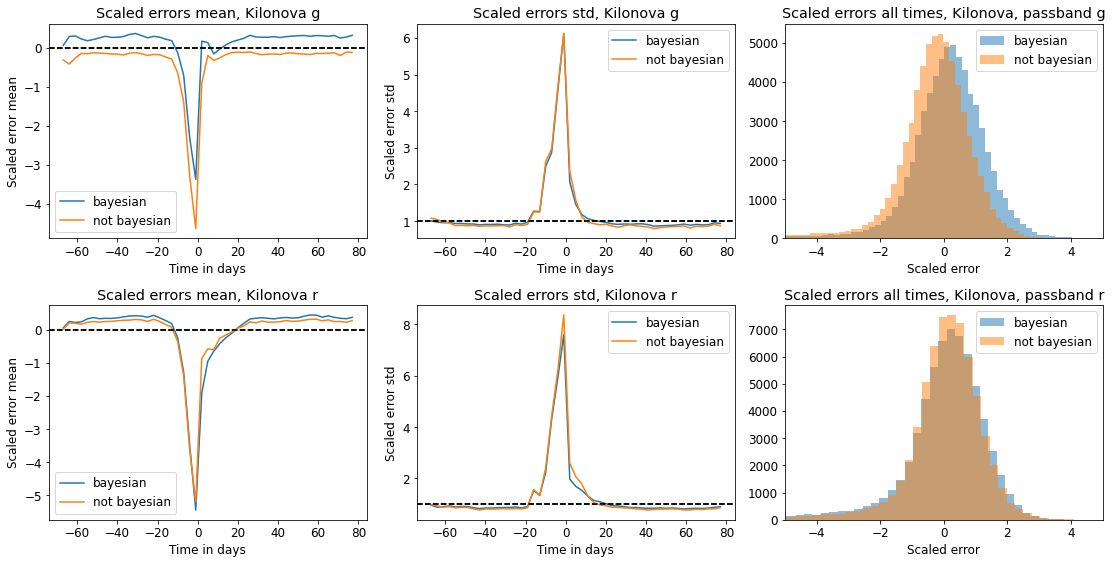

Measured, predicted shapes: (2583, 49, 4) (2583, 49, 2) (2583, 49, 2)
class: SLSN-I, pb: g, tstep: 0, Mean: 0.02449279632067223, std: 1.1244100380877644
class: SLSN-I, pb: g, tstep: 1, Mean: 0.13961677070840642, std: 1.0297684802881992
class: SLSN-I, pb: g, tstep: 2, Mean: 0.19809370827867262, std: 0.9514386131083149
class: SLSN-I, pb: g, tstep: 3, Mean: 0.24156859886986326, std: 0.9158818879553279
class: SLSN-I, pb: g, tstep: 4, Mean: 0.23197613407599957, std: 1.0042281320571609
class: SLSN-I, pb: g, tstep: 5, Mean: 0.23534300189959872, std: 0.9580746950468735
class: SLSN-I, pb: g, tstep: 6, Mean: 0.18572445646988914, std: 0.9223030025625035
class: SLSN-I, pb: g, tstep: 7, Mean: 0.159091599989296, std: 0.9423112737841436
class: SLSN-I, pb: g, tstep: 8, Mean: 0.12653337636013537, std: 0.9017268509076154
class: SLSN-I, pb: g, tstep: 9, Mean: 0.11012646483409308, std: 0.9398885014196987
class: SLSN-I, pb: g, tstep: 10, Mean: 0.06320817452183737, std: 0.9733298812183189
class: SLSN-I, pb:

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
class: SLSN-I, pb: r, tstep: 0, Mean: 0.21843954857999529, std: 1.171457921930962
class: SLSN-I, pb: r, tstep: 1, Mean: 0.4588517953938589, std: 1.0696767102002676
class: SLSN-I, pb: r, tstep: 2, Mean: 0.4334541755462912, std: 1.124634306923664
class: SLSN-I, pb: r, tstep: 3, Mean: 0.43625047210962714, std: 1.0386980919803575
class: SLSN-I, pb: r, tstep: 4, Mean: 0.38285553335907646, std: 1.0001991524000022
class: SLSN-I, pb: r, tstep: 5, Mean: 0.4222227823668731, std: 1.0338603136153344
class: SLSN-I, pb: r, tstep: 6, Mean: 0.39275107778156126, std: 0.9826855367740783
class: SLSN-I, pb: r, tstep: 7, Mean: 0.3416339756736488, std: 0.9808300830891327
class: SLSN-I, pb: r, tstep: 8, Mean: 0.32278305541857755, std: 0.9570084247236329
class: SLSN-I, pb: r, tstep: 9, Mean: 0.34195522518539667, std: 1.0129876067630266
class: SLSN-I, pb: r, tstep: 10, Mean: 0.3210284246101571, std: 1.019777216657565
class: SLSN-I, pb: r, tstep: 11, Mean: 0.25163789000338704, std: 1.0764579

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
Measured, predicted shapes: (2583, 49, 4) (2583, 49, 2) (2583, 49, 2)
class: SLSN-I, pb: g, tstep: 0, Mean: -0.05040376052307963, std: 1.172366951965938
class: SLSN-I, pb: g, tstep: 1, Mean: 0.032209291651626545, std: 1.0735089597945988
class: SLSN-I, pb: g, tstep: 2, Mean: 0.13923001593747864, std: 0.9497089025959152
class: SLSN-I, pb: g, tstep: 3, Mean: 0.16336344559154567, std: 0.9326483813599021
class: SLSN-I, pb: g, tstep: 4, Mean: 0.14554155537355953, std: 1.0237157034754552
class: SLSN-I, pb: g, tstep: 5, Mean: 0.1400110088525352, std: 0.9665920889109296
class: SLSN-I, pb: g, tstep: 6, Mean: 0.10067870501759622, std: 0.9322906168759412
class: SLSN-I, pb: g, tstep: 7, Mean: 0.0627231291539803, std: 0.9889538909253333
class: SLSN-I, pb: g, tstep: 8, Mean: 0.029599553170857384, std: 0.9411886878710076
class: SLSN-I, pb: g, tstep: 9, Mean: 0.014728157937061937, std: 0.9573233877922835
class: SLSN-I, pb: g, tstep: 10, Mean: -0.029370713186871285, std: 1.0204711803

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
class: SLSN-I, pb: r, tstep: 0, Mean: 0.061092599911345774, std: 1.1127781354510886
class: SLSN-I, pb: r, tstep: 1, Mean: 0.2748528547342364, std: 1.0093123805219493
class: SLSN-I, pb: r, tstep: 2, Mean: 0.16476214788615864, std: 1.1059386543281926
class: SLSN-I, pb: r, tstep: 3, Mean: 0.13737409126105193, std: 1.0419145437471218
class: SLSN-I, pb: r, tstep: 4, Mean: 0.08538511805695752, std: 0.9872628685699938
class: SLSN-I, pb: r, tstep: 5, Mean: 0.14991788250237725, std: 1.0456182649105317
class: SLSN-I, pb: r, tstep: 6, Mean: 0.11945943542320668, std: 0.9799807144117288
class: SLSN-I, pb: r, tstep: 7, Mean: 0.0837612799437278, std: 0.9982693218746016
class: SLSN-I, pb: r, tstep: 8, Mean: 0.04549806378547091, std: 0.9793248428006249
class: SLSN-I, pb: r, tstep: 9, Mean: 0.03824262426735668, std: 1.0238700698152445
class: SLSN-I, pb: r, tstep: 10, Mean: -0.0054885564939737355, std: 1.045204608949771
class: SLSN-I, pb: r, tstep: 11, Mean: -0.13880333390947266, std:

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan


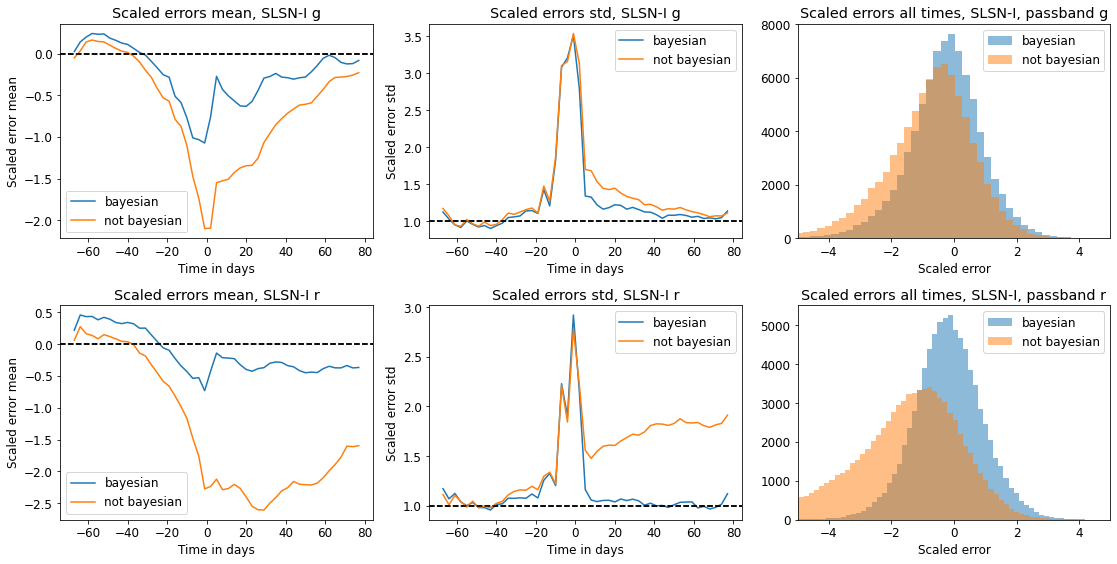

Measured, predicted shapes: (2082, 49, 4) (2082, 49, 2) (2082, 49, 2)
class: TDE, pb: g, tstep: 0, Mean: 0.030449988672377686, std: 0.9703798713819785
class: TDE, pb: g, tstep: 1, Mean: 0.2353267415798288, std: 0.9930286240283657
class: TDE, pb: g, tstep: 2, Mean: 0.24658592175288263, std: 0.990994206401782
class: TDE, pb: g, tstep: 3, Mean: 0.3292592088628803, std: 0.9763510399367198
class: TDE, pb: g, tstep: 4, Mean: 0.3630716691824548, std: 0.9824658890045438
class: TDE, pb: g, tstep: 5, Mean: 0.34270083378734484, std: 0.9650314539035482
class: TDE, pb: g, tstep: 6, Mean: 0.3123199055095901, std: 0.983582686749392
class: TDE, pb: g, tstep: 7, Mean: 0.3264283498286105, std: 1.0002091989880675
class: TDE, pb: g, tstep: 8, Mean: 0.2721842336284479, std: 0.9872618684305721
class: TDE, pb: g, tstep: 9, Mean: 0.250798072954741, std: 0.9634309944494426
class: TDE, pb: g, tstep: 10, Mean: 0.2304473599039646, std: 1.005627611136479
class: TDE, pb: g, tstep: 11, Mean: 0.12181865651187687, std

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
class: TDE, pb: r, tstep: 0, Mean: 0.11758796528474379, std: 0.9745733224771983
class: TDE, pb: r, tstep: 1, Mean: 0.1607930718531942, std: 0.9480204287576265
class: TDE, pb: r, tstep: 2, Mean: 0.15962769850133957, std: 0.9217768741464042
class: TDE, pb: r, tstep: 3, Mean: 0.20587383962287092, std: 0.9053381636549618
class: TDE, pb: r, tstep: 4, Mean: 0.2379397567375515, std: 0.9010152548499912
class: TDE, pb: r, tstep: 5, Mean: 0.26166787364511707, std: 0.9285735888634353
class: TDE, pb: r, tstep: 6, Mean: 0.21354205869723597, std: 0.950959390878453
class: TDE, pb: r, tstep: 7, Mean: 0.2845550876655941, std: 0.9188918635198838
class: TDE, pb: r, tstep: 8, Mean: 0.2385335380915549, std: 0.9353577707966647
class: TDE, pb: r, tstep: 9, Mean: 0.21079107781130949, std: 0.9334494175121943
class: TDE, pb: r, tstep: 10, Mean: 0.16972176660968757, std: 0.9549086918018904
class: TDE, pb: r, tstep: 11, Mean: 0.082453356734332, std: 1.159466763521704
class: TDE, pb: r, tstep: 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
Measured, predicted shapes: (2082, 49, 4) (2082, 49, 2) (2082, 49, 2)
class: TDE, pb: g, tstep: 0, Mean: 0.007514795624633609, std: 0.9796670650686096
class: TDE, pb: g, tstep: 1, Mean: 0.18987691859588246, std: 1.0213832057379995
class: TDE, pb: g, tstep: 2, Mean: 0.20422451979960915, std: 0.9935586076331641
class: TDE, pb: g, tstep: 3, Mean: 0.28216017005554156, std: 1.0074736103597142
class: TDE, pb: g, tstep: 4, Mean: 0.3162932575766573, std: 0.9833022031393293
class: TDE, pb: g, tstep: 5, Mean: 0.2754412823622792, std: 0.9409000619105714
class: TDE, pb: g, tstep: 6, Mean: 0.2538025792220822, std: 0.9782060360964988
class: TDE, pb: g, tstep: 7, Mean: 0.239008839585735, std: 0.9861832476128253
class: TDE, pb: g, tstep: 8, Mean: 0.19603826018568032, std: 0.9925729624799366
class: TDE, pb: g, tstep: 9, Mean: 0.16021963565030134, std: 0.9742003156092859
class: TDE, pb: g, tstep: 10, Mean: 0.12835880576918376, std: 1.0198934374949524
class: TDE, pb: g, tstep: 11, Mea

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
class: TDE, pb: r, tstep: 0, Mean: 0.05702362201553275, std: 0.9709279209725927
class: TDE, pb: r, tstep: 1, Mean: 0.07683732114049126, std: 0.9398124047886165
class: TDE, pb: r, tstep: 2, Mean: 0.019234899847170746, std: 0.8956583374497631
class: TDE, pb: r, tstep: 3, Mean: 0.08494306721746804, std: 0.9015106595112291
class: TDE, pb: r, tstep: 4, Mean: 0.10987634240328917, std: 0.8981857810638338
class: TDE, pb: r, tstep: 5, Mean: 0.12791652259859115, std: 0.9148119120023271
class: TDE, pb: r, tstep: 6, Mean: 0.09030272873037122, std: 0.9428671050985576
class: TDE, pb: r, tstep: 7, Mean: 0.15175378147231208, std: 0.9286389609270433
class: TDE, pb: r, tstep: 8, Mean: 0.08425405388883778, std: 0.9429406919960788
class: TDE, pb: r, tstep: 9, Mean: 0.05074548154680049, std: 0.929736752679964
class: TDE, pb: r, tstep: 10, Mean: 0.0002877426445856133, std: 0.9541508957019317
class: TDE, pb: r, tstep: 11, Mean: -0.09922505310335723, std: 1.187722082384256
class: TDE, pb: 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan


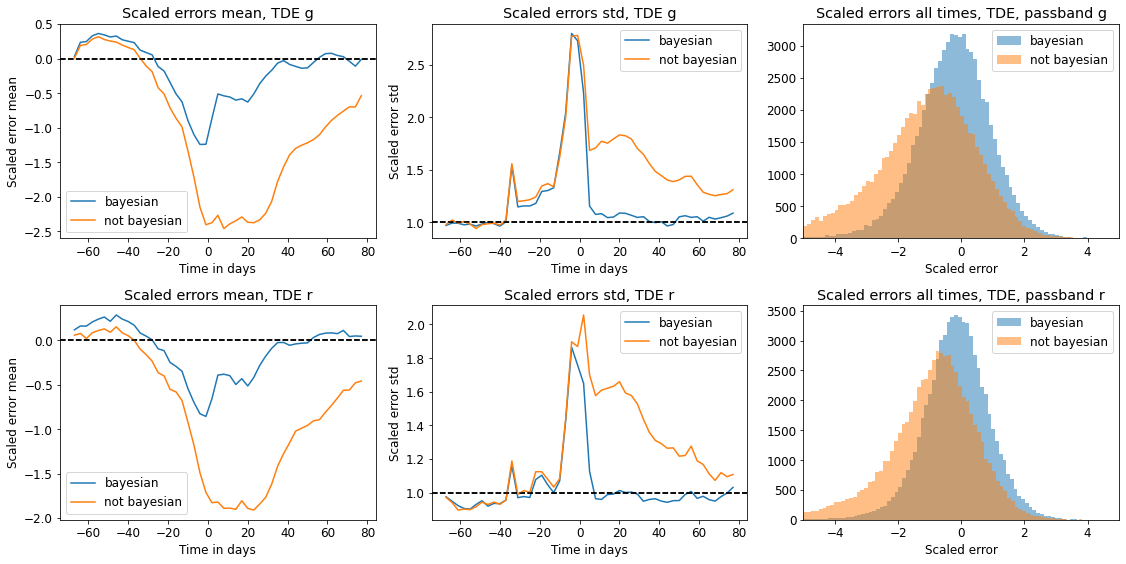

In [14]:
# @title Scaled error plots
# Combine above three cells
font = {'family': 'normal',
        'size': 12}
matplotlib.rc('font', **font)

for class_num in class_nums_all:    
    class_nums = (class_num,)
    class_name = sntypes_map[class_num]
    fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(16,8))
    plt.title(f"Scaled errors class: {class_name}")
    for bayesian in [True, False]: 
        nn_architecture_change = f"mcdropout_TCN_{'probabilistic_' if probabilistic else ''}bayesian{bayesian}_uncertainties{use_uncertainties}_predictfuture{npred}point_normalised{normalise}_dropout{dropout_rate}_units{nunits}_batchsize{batch_size}_lr{learning_rate}"
   
        preparearrays = PrepareTrainingSetArrays(passbands, contextual_info, data_dir, save_dir, training_set_dir, redo, get_data_func, use_gp_interp)
        X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
        timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
            preparearrays.make_training_set(class_nums, nsamples, otherchange, nprocesses, extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties, only_use_objids=objids_to_use[class_num])
        
        fig_dir = os.path.join(os.path.join(SCRIPT_DIR, '..', 'plots'), "model_{}_ci{}_ns{}_c{}".format(otherchange, contextual_info, nsamples, class_nums))
        model, model_name = train_model(X_train, X_test, y_train, y_test, yerr_train, yerr_test, fig_dir=fig_dir, epochs=train_epochs, retrain=retrain, passbands=passbands, model_change=nn_architecture_change, reframe=reframe_problem, probabilistic=probabilistic, train_from_last_stop=train_from_last_stop, batch_size=batch_size, nunits=nunits, use_uncertainties=use_uncertainties, bayesian=bayesian, dropout_rate=dropout_rate, learning_rate=learning_rate)

        # Analyse predictive uncertainties
        nobjects, ntimesteps, nfeatures = y_test.shape
        npassbands = len(passbands)
        sntypes_map = helpers.get_sntypes()

        if bayesian:
            sampled_ypred = []
            sampled_ystd = []
            draws = []
            ns = 100
            for i in range(ns):
                sampled_yhat = model(X_test)
                sampled_ypred.append(np.asarray(sampled_yhat.mean()))
                sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
                draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
            plot_mean_ypred = np.mean(np.array(draws), axis=0)
            plot_sigma_ypred = np.std(np.array(draws), axis=0)
        else:
            yhat = model(X_test)
            plot_mean_ypred = np.asarray(yhat.mean())
            plot_sigma_ypred = np.asarray(yhat.stddev())


        # Analyse predictive uncertainties continued...
        import imageio
        print("Measured, predicted shapes:", y_test.shape, plot_mean_ypred.shape, plot_sigma_ypred.shape)

        # Compute scaled error and scale yperr
        yt = y_test[:,:,:2]
        yterr = y_test[:,:,2:]
        yp = plot_mean_ypred
        yperr = 0.2*plot_sigma_ypred

        maskzeros = (yterr == 0)
        scaled_error = (yp - yt)/np.sqrt(yperr**2 + yterr**2)
        scaled_error[maskzeros] = None
        
        plot_times = np.arange(-67, 80, 3)

        mean_scalederrors = {'g': [], 'r': []}
        std_scalederrors = {'g': [], 'r': []}
        for pbidx, pb in enumerate(passbands):
            images = []
            for tstep, t in enumerate(plot_times):
                tstep_mask = (np.abs(timesX_test[:,1:] - t)) < 1.5  # Mask time steps closest to t. No more than one index per object
                x = scaled_error[:,:,pbidx][tstep_mask]
                xmean = np.nanmean(x)
                xstd = np.nanstd(x)
                # fig_t = plt.figure()
                # ax_t = plt.gca()
                # ax_t.set_title(f"DNN scaled errors class: {class_name} pb: {pb} tstep: {tstep}, mean: {round(xmean,3)}, std: {round(xstd,3)}")
                # ax_t.hist(x, bins=200)
                # ax_t.set_xlim(-5,5)
                # ax_t.set_xlabel("Scaled error")
                # filename = f"gif_images/{class_name}_DNN_scaled_errors_{pb}_{tstep}_mcdropout{bayesian}.png"
                # fig_t.savefig(filename)
                # plt.show()
                print(f"class: {class_name}, pb: {pb}, tstep: {tstep}, Mean: {xmean}, std: {xstd}")
                mean_scalederrors[pb].append(xmean)
                std_scalederrors[pb].append(xstd)
            #     images.append(imageio.imread(filename))
            # imageio.mimsave(f'{class_name}_DNN_scaled_errors_{pb}_mcdropout{bayesian}.gif', images)
            # plt.figure()
            axs[pbidx,0].set_title(f"Scaled errors mean, {class_name} {pb}")
            axs[pbidx,0].plot(plot_times, mean_scalederrors[pb], label=('bayesian' if bayesian else 'not bayesian'))
            axs[pbidx,0].axhline(y=0, color='k', linestyle='--')
            axs[pbidx,0].set_xlabel("Time in days")
            axs[pbidx,0].set_ylabel("Scaled error mean")
            axs[pbidx,0].legend()
            # plt.savefig(f"{class_num}_DNN Scaled errors mean, passband {pb}.pdf")
            # plt.figure()
            axs[pbidx,1].set_title(f"Scaled errors std, {class_name} {pb}")
            axs[pbidx,1].plot(plot_times, std_scalederrors[pb], label=('bayesian' if bayesian else 'not bayesian'))
            axs[pbidx,1].axhline(y=1, color='k', linestyle='--')
            axs[pbidx,1].set_xlabel("Time in days")
            axs[pbidx,1].set_ylabel("Scaled error std")
            axs[pbidx,1].legend()
            # plt.savefig(f"{class_num}_DNN Scaled errors std, passband {pb}.pdf")

            print("Scaled_error shape:", scaled_error.shape, scaled_error.flatten().shape)
            # plt.figure()
            axs[pbidx,2].set_title(f"Scaled errors all times, {class_name}, passband {pb}")
            axs[pbidx,2].hist(scaled_error[:,:,pbidx].flatten(), bins=500, alpha=0.5, label=('bayesian' if bayesian else 'not bayesian'));
            axs[pbidx,2].set_xlim(-5,5)
            axs[pbidx,2].set_xlabel("Scaled error")
            axs[pbidx,2].legend()
            # plt.savefig(f"{class_num}_DNN Scaled errors, passband {pb}.pdf")
            print(f"Mean: {np.mean(scaled_error.flatten())}, std: {np.std(scaled_error.flatten())}")
    plt.tight_layout()
    fig.savefig(f"{class_name}_DNN_Scaled_errors_scaleyperr.pdf")
    # plt.show()
    # plt.close()
    plt.show()

In [15]:
yt = y_test[:,:,:2]
yterr = y_test[:,:,2:]
yp = plot_mean_ypred
yperr = 0.2*plot_sigma_ypred

maskzeros = (yterr == 0)
scaled_error = (yp - yt)/np.sqrt(yperr**2 + yterr**2)
scaled_error[maskzeros] = None

np.nanstd(scaled_error[:,23:,0].flatten())

1.6998027069126989

In [16]:
#@title Paper plot - example anomaly scores 3-plot
# npassbands = len(passbands)
# class_nums = (1,)
# preparearrays = PrepareTrainingSetArrays(passbands, contextual_info, data_dir, save_dir, training_set_dir, redo, get_data_func, use_gp_interp)
# X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
# timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
#     preparearrays.make_training_set(class_nums, nsamples, otherchange, nprocesses, extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties, train_size=0.99)

# paper_objid = "1_18581367"#"1_124486590"  # '1_132490785'
# paper_idx = int(np.where(objids_test == paper_objid)[0])
# lc_classnum = int(paper_objid.split('_')[0])
# light_curves = {}
# light_curves[lc_classnum] = get_data(get_data_func=get_data_func, class_num=lc_classnum, data_dir=data_dir,
#                                   save_dir=save_dir, passbands=passbands, known_redshift=known_redshift,
#                                   nprocesses=nprocesses, redo=False, calculate_t0=False)
# lc = light_curves[lc_classnum][paper_objid]
# sntypes_map = helpers.get_sntypes()

# fig = plt.figure(figsize=(10.4, 6))
# ax1 = plt.subplot(221)
# ax2 = plt.subplot(223, sharex=ax1)
# ax3 = plt.subplot(122)
# for pbidx, pb in enumerate(passbands):
#     pbmask = lc['passband'] == pb
#     ax1.errorbar(lc[pbmask]['time'].data, lc[pbmask]['flux'].data, yerr=lc[pbmask]['fluxErr'].data, fmt='.', color=COLPB[pb], label=f'${pb}$-band obs')

# ascores = []
# ascores_nll = []
# model_classnums = (1,2,3,51,60,64)
# model_classnames = [sntypes_map[c] for c in model_classnums]
# for model_classnum in model_classnums:
#     print(f"Getting predictions for model {model_classnum}")
#     model_filepath = f"plots/model_linear_spline_with_unc_inXandy_ci()_ns1_c({model_classnum},)/keras_model_epochs10000_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.4_units30_batchsize64_lr0.001/keras_model_epochs10000_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.4_units30_batchsize64_lr0.001.hdf5"
#     model = load_model(model_filepath, custom_objects={'loss': negloglike_with_error, 'TCN': TCN})
#     sampled_ypred = []
#     sampled_ystd = []
#     draws = []
#     ns = 100
#     for i in range(ns):
#         sampled_yhat = model(X_test)
#         sampled_ypred.append(np.asarray(sampled_yhat.mean()))
#         sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
#         draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
#     plot_mean_ypred = np.mean(np.array(draws), axis=0)
#     plot_sigma_ypred = np.std(np.array(draws), axis=0)

#     for pbidx, pb in enumerate(passbands):
#         pbmask = lc['passband'] == pb
#         # for drawidx in range(ns):
#         #     ax1.plot(timesX_test[paper_idx][1:], sampled_ypred[drawidx][paper_idx][:, pbidx], color=COLPB[pb], alpha=0.05)
#         # ax1.plot(timesX_test[paper_idx][1:], np.median(np.array(sampled_ypred)[:, paper_idx, :, pbidx], axis=0), label=f'${pb}$-band pred', color=COLPB[pb], linewidth=2, linestyle='-')  # median

#     chi2 = 0
#     negloglike = 0
#     maskzeros = True
#     for pbidx in range(npassbands):
#         yt = y_test[paper_idx, :, pbidx]
#         yterr = yerr_test[paper_idx, :, pbidx]
#         yp = plot_mean_ypred[paper_idx, :, pbidx]
#         yperr = plot_sigma_ypred[paper_idx, :, pbidx]
#         maskzeros = ((yterr != 0) * (np.isfinite(yterr))) & maskzeros
#         chi2 += ((yp - yt)/yterr)**2
#         negloglike += 0.5 * (yp - yt)**2 / (yterr*2 + yperr**2) + 0.5*np.log(yterr**2 + yperr**2) + 0.5*np.log(2*np.pi)
#     chi2 = chi2[maskzeros] / npassbands
#     negloglike = negloglike[maskzeros]/npassbands
#     chi2cumsum = np.cumsum(chi2)/np.arange(1, len(chi2)+1)
#     negloglikecumsum = np.cumsum(negloglike)/np.arange(1, len(negloglike)+1)
#     ascores.append(sum(chi2)/len(chi2))
#     ascores_nll.append(sum(negloglike)/len(negloglike))
#     # ax1.text(0.05, 0.95, f"$\chi^2 = {round(max(chi2), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure) #1
#     # ax1.text(0.05, 0.95, f"{class_name}", transform=fig.transFigure) #1
#     # ax1.legend(frameon=True, fontsize=13, loc='upper left')
#     ax2.plot(timesX_test[paper_idx][1:][maskzeros], chi2cumsum, lw=2, label=sntypes_map[model_classnum]) #2
#     # ax2.text(0.05, 0.95, f"$\chi^2 = {round(np.sum(chi2)/len(yt), 3)}$", horizontalalignment='left', verticalalignment='center', transform=ax2.transAxes) #2

# barplt = ax3.bar(np.arange(len(model_classnums)), np.exp(-np.array(ascores)/2), color='tab:blue', alpha=0.5)
# ax3.set_xticks(np.arange(len(model_classnums)), model_classnames)
# ax3.set_xticklabels(np.insert(model_classnames, 0, 0), rotation=90)

# ax1.legend(fontsize=13)
# ax2.legend(fontsize=13)
# ax1.axes.xaxis.set_ticklabels([])
# ax1.tick_params(axis='y', labelsize=15)
# ax2.tick_params(axis='x', labelsize=15) #2
# ax2.tick_params(axis='y', labelsize=15) #2
# ax3.tick_params(axis='x', labelsize=13) #2
# ax3.tick_params(axis='y', labelsize=15) #2
# ax2.set_xlim(-67, 77)
# # ax1.set_ylim((-300, 2400))
# ax1.set_ylabel("Relative flux", fontsize=15)
# ax2.set_xlabel("Time since trigger [days]", fontsize=15) #2
# ax2.set_ylabel("Anomaly score", fontsize=15) #2
# ax3.set_ylabel("Predicitive density", fontsize=15) #2
# plt.tight_layout()
# fig.subplots_adjust(hspace=0) #2
# plt.savefig(f"DNN_model_fitting-{paper_objid}_comparemodels.pdf") #2
# plt.show()
# plt.close()



In [17]:
# ax1.plot(timesX_test[paper_idx][1:][-npred:], sampled_ypred[drawidx][paper_idx][:, pbidx], color=COLPB[pb], alpha=0.05)
# timesX_test[paper_idx][1:].shape
# sampled_ypred[drawidx][paper_idx][:, pbidx]

In [18]:
#@title Similarity matrix function definitions
from transomaly import helpers
sntypes_map = helpers.get_sntypes()

def get_similarity_matrix(class_nums, model_filepaths, preparearrays, nprocesses, extrapolate_gp, nsamples, ignore_class_names_test_on=[]):
    X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
    timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
        preparearrays.make_training_set(class_nums=class_nums, nsamples=1, otherchange='getKnAndOtherTypes', nprocesses=nprocesses, extrapolate_gp=extrapolate_gp, reframe=False, npred=1, normalise=normalise, use_uncertainties=use_uncertainties)

    similarity_matrix_chi2_withpredunc = {}
    similarity_matrix_chi2_withoutpredunc = {}
    similarity_matrix_nll_withpredunc = {}
    similarity_matrix_nll_withoutpredunc = {}
    anomaly_scoreslist_chi2_dict = {}
    anomaly_scores_nll_wpredunc_dict = {}
    anomaly_score_chi2_wpredunc_dict = {}
    anomaly_score_nll_withoutpredunc_dict = {}
    for class_name, model_filepath in model_filepaths.items():
        print(class_name)

        if not os.path.exists(model_filepath):
            print("No model found at", model_filepath)
            continue

        saved_scores_fp = os.path.join(os.path.dirname(model_filepath), f'similarity_scores_chi2_withpredunc_10000-0.2_{class_nums}_saveallmetrics-fixedtypoinmetric_scaleyperrby0point2.json')
  
        if os.path.exists(saved_scores_fp):
            print("Using saved similarity scores")
            with open(saved_scores_fp, 'r') as fp:
                similarity_scores_chi2_withpredunc = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'similarity_scores_chi2_withoutpredunc_'), 'r') as fp:
                similarity_scores_chi2_withoutpredunc = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'similarity_scores_nll_withpredunc_'), 'r') as fp:
                similarity_scores_nll_withpredunc = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'similarity_scores_nll_withoutpredunc_'), 'r') as fp:
                similarity_scores_nll_withoutpredunc = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'anomaly_scoreslist_chi2_'), 'r') as fp:
                anomaly_scoreslist_chi2 = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'anomaly_scores_nll_wpredunc'), 'r') as fp:
                anomaly_scores_nll_wpredunc = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'anomaly_scores_chi2_withpredunc'), 'r') as fp:
                anomaly_scores_chi2_withpredunc = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'anomaly_scores_nll_withoutpredunc'), 'r') as fp:
                anomaly_scores_nll_withoutpredunc = json.load(fp)
        else:
            print("Saving similarity scores...")
            model = load_model(model_filepath, custom_objects={'loss': negloglike_with_error(), 'TCN': TCN})
            similarity_scores_chi2_withpredunc, similarity_scores_chi2_withoutpredunc, similarity_scores_nll_withpredunc, similarity_scores_nll_withoutpredunc, anomaly_scoreslist_chi2, anomaly_scores_nll_wpredunc, anomaly_scores_chi2_withpredunc, anomaly_scores_nll_withoutpredunc = similarity_metric(model, X_test, y_test, yerr_test, labels_test,
                                                                       objids_test, nsamples)
            with open(saved_scores_fp, 'w') as fp:
                json.dump(similarity_scores_chi2_withpredunc, fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'similarity_scores_chi2_withoutpredunc_'), 'w') as fp:
                json.dump(similarity_scores_chi2_withoutpredunc, fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'similarity_scores_nll_withpredunc_'), 'w') as fp:
                json.dump(similarity_scores_nll_withpredunc, fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'similarity_scores_nll_withoutpredunc_'), 'w') as fp:
                json.dump(similarity_scores_nll_withoutpredunc, fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'anomaly_scoreslist_chi2_'), 'w') as fp:
                json.dump(anomaly_scoreslist_chi2, fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'anomaly_scores_nll_wpredunc'), 'w') as fp:
                json.dump(anomaly_scores_nll_wpredunc, fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'anomaly_scores_chi2_withpredunc'), 'w') as fp:
                json.dump(anomaly_scores_chi2_withpredunc, fp)
            with open(saved_scores_fp.replace('similarity_scores_chi2_withpredunc_', 'anomaly_scores_nll_withoutpredunc'), 'w') as fp:
                json.dump(anomaly_scores_nll_withoutpredunc, fp)

        similarity_matrix_chi2_withpredunc[class_name] = similarity_scores_chi2_withpredunc
        similarity_matrix_chi2_withoutpredunc[class_name] = similarity_scores_chi2_withoutpredunc
        similarity_matrix_nll_withpredunc[class_name] = similarity_scores_nll_withpredunc
        similarity_matrix_nll_withoutpredunc[class_name] = similarity_scores_nll_withoutpredunc
        anomaly_scoreslist_chi2_dict[class_name] = anomaly_scoreslist_chi2
        anomaly_scores_nll_wpredunc_dict[class_name] = anomaly_scores_nll_wpredunc
        anomaly_score_chi2_wpredunc_dict[class_name] = anomaly_scores_chi2_withpredunc
        anomaly_score_nll_withoutpredunc_dict[class_name] = anomaly_scores_nll_withoutpredunc

    similarity_matrix_chi2_withpredunc = pd.DataFrame(similarity_matrix_chi2_withpredunc)
    similarity_matrix_chi2_withoutpredunc = pd.DataFrame(similarity_matrix_chi2_withoutpredunc)
    similarity_matrix_nll_withpredunc = pd.DataFrame(similarity_matrix_nll_withpredunc)
    similarity_matrix_nll_withoutpredunc = pd.DataFrame(similarity_matrix_nll_withoutpredunc)

    similarity_matrix_nll_withpredunc.to_csv('DNN_similarity_matrix.csv')
    similarity_matrix_chi2_withoutpredunc.to_csv('DNN_similarity_matrix_chi2.csv')

    print(similarity_matrix_chi2_withpredunc)

    similarity_matrix_chi2_withpredunc = similarity_matrix_chi2_withpredunc.drop(ignore_class_names_test_on)
    similarity_matrix_chi2_withoutpredunc = similarity_matrix_chi2_withoutpredunc.drop(ignore_class_names_test_on)
    similarity_matrix_nll_withpredunc = similarity_matrix_nll_withpredunc.drop(ignore_class_names_test_on)
    similarity_matrix_nll_withoutpredunc = similarity_matrix_nll_withoutpredunc.drop(ignore_class_names_test_on)

    similarity_matrix_chi2_withpredunc = similarity_matrix_chi2_withpredunc.reindex([sntypes_map[c] for c in class_nums])
    similarity_matrix_chi2_withoutpredunc = similarity_matrix_chi2_withoutpredunc.reindex([sntypes_map[c] for c in class_nums])
    similarity_matrix_nll_withpredunc = similarity_matrix_nll_withpredunc.reindex([sntypes_map[c] for c in class_nums])
    similarity_matrix_nll_withoutpredunc = similarity_matrix_nll_withoutpredunc.reindex([sntypes_map[c] for c in class_nums])

    return similarity_matrix_chi2_withpredunc, similarity_matrix_chi2_withoutpredunc, similarity_matrix_nll_withpredunc, similarity_matrix_nll_withoutpredunc, anomaly_scoreslist_chi2_dict, anomaly_scores_nll_wpredunc_dict, anomaly_score_chi2_wpredunc_dict, anomaly_score_nll_withoutpredunc_dict


def similarity_metric(model, X_test, y_test, yerr_test, labels_test, objids_test, nsamples):
    nobjects, ntimesteps, npassbands = X_test.shape
    npassbands = 2

    sampled_ypred = []
    sampled_ystd = []
    draws = []
    ns = 100
    for drawidx in range(ns):
        sampled_yhat = model(X_test)
        sampled_ypred.append(np.asarray(sampled_yhat.mean()))
        sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
        draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
    y_pred_mean = np.mean(np.array(draws), axis=0)
    y_pred_sigma = np.std(np.array(draws), axis=0)
    y_pred_draws = np.array(draws)
    y_pred_median = np.median(y_pred_draws, axis=0)
    
    class_nums = np.unique(labels_test)
    sntypes_map = helpers.get_sntypes()
    class_names = [sntypes_map[class_num] for class_num in class_nums]

    anomaly_scores = {key: [] for key in class_names}
    anomaly_scores_chi2 = {key: [] for key in class_names}
    anomaly_scores_chi2_withpredunc =  {key: [] for key in class_names}
    anomaly_scores_nll_withoutpredunc = {key: [] for key in class_names}
    for idx in range(nobjects):
        sidx = idx * nsamples  # Assumes like samples are in order

        # Get anomaly scores
        chi2_samples = []
        like_samples = []
        negloglike_samples = []
        maskzeros = []
        for s in range(nsamples):
            npb = 0
            chi2 = 0
            like = 0
            negloglike = 0
            chi2_with_predunc = 0
            negloglike_without_predunc = 0
            maskzeros = True
            for pbidx in range(npassbands):
                yt = y_test[sidx+s, :, pbidx]
                yterr = yerr_test[sidx+s, :, pbidx]
                yp = y_pred_mean[sidx+s, :, pbidx]
                yperr = 0.2*y_pred_sigma[sidx+s, :, pbidx]
                maskzeros = ((yterr != 0) * (np.isfinite(yterr))) & maskzeros
                try:
                    chi2 += ((yp - yt)/yterr)**2
                    like += np.exp(-0.5*(yp-yt)**2 / (yterr**2+yperr**2)) * (2*np.pi*(yterr**2+yperr**2))**-0.5
                    negloglike += 0.5 * (yp - yt)**2 / (yterr**2 + yperr**2) + 0.5 *np.log(yterr**2 + yperr**2) + 0.5*np.log(2*np.pi)
                    chi2_with_predunc += (yp - yt)**2 / (yterr**2 + yperr**2)
                    negloglike_without_predunc += 0.5 * (yp - yt)**2 / (yterr**2) + 0.5 *np.log(yterr**2) + 0.5*np.log(2*np.pi)
                    npb += 1
                except ValueError as e:
                    print(f"Failed chi2 object {objids_test[sidx + s]}", e)
            if not np.any(maskzeros):
                continue
            chi2 = chi2[maskzeros] / npb
            like = like[maskzeros] / npb
            negloglike = negloglike[maskzeros] / npb
            chi2_with_predunc = chi2_with_predunc[maskzeros] / npb
            negloglike_without_predunc = negloglike_without_predunc[maskzeros] / npb
            chi2_samples.append(chi2)
            like_samples.append(like)
            negloglike_samples.append(negloglike)
        if len(chi2_samples) == 0:
            continue
        anomaly_score_samples = np.array(negloglike_samples)
        anomaly_score_samples_chi2 = np.array(chi2_samples)
        anomaly_score_mean = np.mean(anomaly_score_samples, axis=0)
        anomaly_score_mean_chi2 = np.mean(anomaly_score_samples_chi2, axis=0)

        anomaly_score_max = np.nanmean(anomaly_score_mean)
        anomaly_score_max_chi2 = np.nanmean(anomaly_score_mean_chi2)

        class_name = sntypes_map[labels_test[sidx]]
        anomaly_scores[class_name].append(anomaly_score_max)
        anomaly_scores_chi2[class_name].append(anomaly_score_max_chi2)
        anomaly_scores_chi2_withpredunc[class_name].append(np.nanmean(chi2_with_predunc))
        anomaly_scores_nll_withoutpredunc[class_name].append(np.nanmean(negloglike_without_predunc))

    similarity_score_nll_withpredunc = {key: [] for key in class_names}
    similarity_score_nll_withoutpredunc = {key: [] for key in class_names}
    similarity_score_chi2_withpredunc = {key: [] for key in class_names}
    similarity_score_chi2_withoutpredunc = {key: [] for key in class_names}
    for c in class_names:
        similarity_score_chi2_withpredunc[c] = np.median(anomaly_scores_chi2_withpredunc[c])
        similarity_score_chi2_withoutpredunc[c] = np.median(anomaly_scores_chi2[c])
        similarity_score_nll_withpredunc[c] = np.median(anomaly_scores[c])
        similarity_score_nll_withoutpredunc[c] = np.median(anomaly_scores_nll_withoutpredunc[c])

    return similarity_score_chi2_withpredunc, similarity_score_chi2_withoutpredunc, similarity_score_nll_withpredunc, similarity_score_nll_withoutpredunc, anomaly_scores_chi2, anomaly_scores, anomaly_scores_chi2_withpredunc, anomaly_scores_nll_withoutpredunc


def plot_similarity_matrix(similarity_matrix):
    font = {'family': 'normal',
            'size': 36}
    matplotlib.rc('font', **font)

    xrange, yrange = similarity_matrix.shape
    similarity_matrix = similarity_matrix.T
    # similarity_matrix = similarity_matrix[
    #     ['SNIa', 'SNIa-x', 'SNII', 'SNIbc', 'SLSN-I', 'TDE', 'AGN', 'SNIIn', 'Ia-91bg', 'CART', 'TDE', 'PISN',
    #      'Kilonova']]
    xlabels = similarity_matrix.columns.values
    ylabels = similarity_matrix.index.values
    
    sntypes_map = helpers.get_sntypes()
    ylabels = [sntypes_map[ylabel] for ylabel in ylabels]

    minval = 0
    maxval = min(8, similarity_matrix.values.max())
    plt.figure(figsize=(15,12))
    im = plt.imshow(similarity_matrix, cmap=plt.cm.RdBu_r)#, vmin=minval, vmax=maxval)#, norm=colors.LogNorm())

    cb =  plt.colorbar(im, fraction=0.028, pad=0.04)
    # cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=27)
    plt.xticks(np.arange(xrange), xlabels, rotation=90, fontsize=27)
    plt.yticks(np.arange(yrange), ylabels, fontsize=27)

    thresh_q3 = 0.75 * maxval
    thresh_q1 = 0.25 * maxval
    for i in range(xrange):
        for j in range(yrange):
            c = similarity_matrix.iloc[j, i]
            if c > 100:
                cell_text = f"{c:.0f}"
            elif c > 10:
                cell_text = f"{c:.1f}"
            else:
                cell_text = f"{c:.2f}"
            plt.text(i, j, cell_text, va='center', ha='center', fontsize=24, color="white" if c < thresh_q1 or c > thresh_q3 else "black",)

    plt.ylabel('Training set')
    plt.xlabel('Testing set')
    plt.tight_layout()
    print("Saving matrix plot...")
    plt.savefig("similarity_matrix_epochs10000dpout0.2_cumsum_moretestclasses_scaleyperrby0point2.pdf")

1
Using saved similarity scores
2
Using saved similarity scores
3
Using saved similarity scores
51
Using saved similarity scores
60
Using saved similarity scores
64
Using saved similarity scores


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


                 1         2         3         51        60        64
SNIa-norm  0.589479  0.526604  0.596926  0.630021  0.528910  0.615913
SNII       0.630765  0.551459  0.649147  0.701269  0.562101  0.623909
SNIbc      0.611535  0.536665  0.601816  0.595833  0.537413  0.654917
Kilonova   1.554080  1.364284  1.598655  0.542904  1.409072  1.371738
SLSN-I     0.481513  0.449651  0.498478  1.005106  0.364122  0.488389
PISN       0.546798  0.419668  0.482846  1.120132  0.334384  0.622978
ILOT       0.565073  0.469703  0.547768  1.023383  0.368822  0.583810
CART       0.618957  0.543911  0.619559  0.655985  0.536032  0.650476
TDE        0.555047  0.506397  0.589509  0.804395  0.543225  0.423115
uLens-BSR  0.949491  0.778677  0.877454  1.553283  0.916476  0.913995
Saving matrix plot...


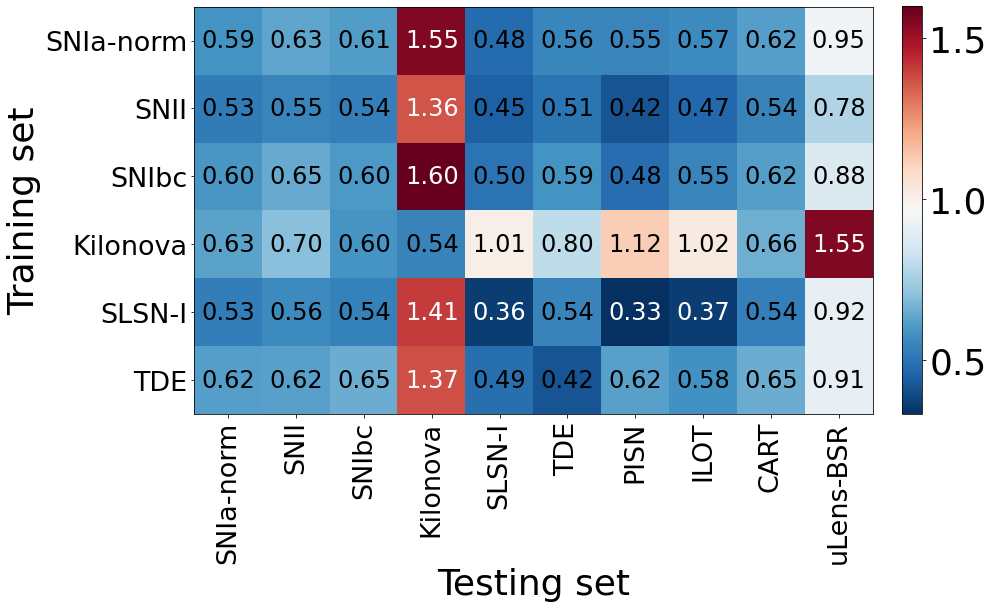

In [19]:
#@title # Plot similarity matrix
preparearrays = PrepareTrainingSetArrays(passbands, contextual_info, data_dir, save_dir, training_set_dir, redo, get_data_func, use_gp_interp)
otherchange = 'linear_spline_with_unc_inXandy'#"using_only_goodobjectsw20datapoints"  # linear_spline_with_unc_inXandy
train_epochs = 10000 #2001 # 10000

class_nums = [1, 2, 3, 51, 60, 64, 61, 62, 63, 90]#, 92]
model_filepaths = {}

model_filepaths[1]  = f'plots/model_{otherchange}_ci()_ns1_c(1,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
model_filepaths[2]  = f'plots/model_{otherchange}_ci()_ns1_c(2,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
model_filepaths[3]  = f'plots/model_{otherchange}_ci()_ns1_c(3,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
model_filepaths[51] = f'plots/model_{otherchange}_ci()_ns1_c(51,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
model_filepaths[60] = f'plots/model_{otherchange}_ci()_ns1_c(60,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
model_filepaths[64] = f'plots/model_{otherchange}_ci()_ns1_c(64,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'


similarity_matrix_chi2_withpredunc, similarity_matrix_chi2_withoutpredunc, similarity_matrix_nll_withpredunc, similarity_matrix_nll_withoutpredunc, anomaly_scoreslist_chi2_dict, anomaly_scores_nll_wpredunc_dict, anomaly_score_chi2_wpredunc_dict, anomaly_score_nll_withoutpredunc_dict = get_similarity_matrix(class_nums, model_filepaths, preparearrays, nprocesses=None, extrapolate_gp=False, nsamples=1, ignore_class_names_test_on=[])
plot_similarity_matrix(similarity_matrix_chi2_withpredunc)
# plot_similarity_scatter_plot(similarity_matrix)

Using model SNIa-norm


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


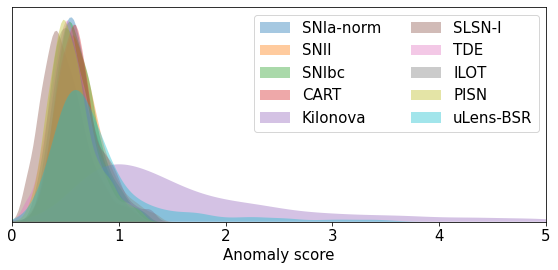

Using model SNII


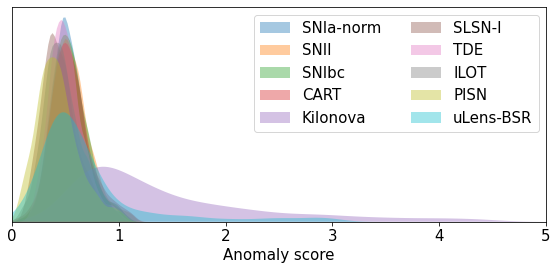

Using model SNIbc


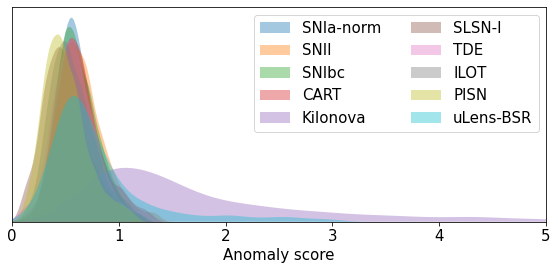

Using model Kilonova


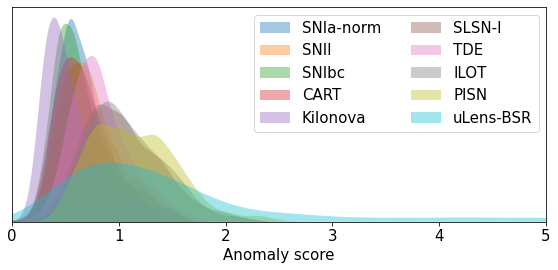

Using model SLSN-I


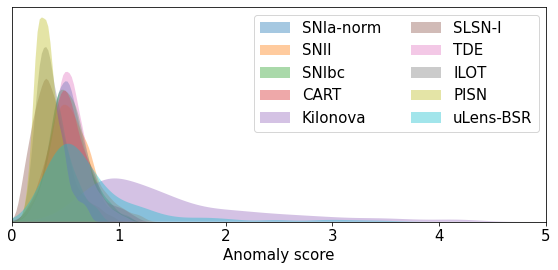

Using model TDE


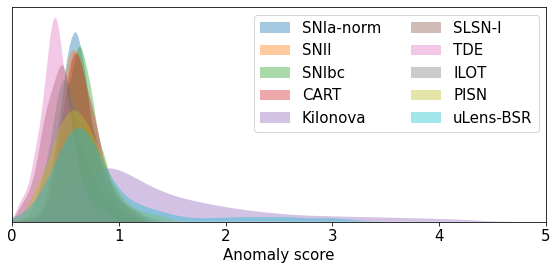

In [20]:
#@title Anomaly score distribution plots
from transomaly import helpers
sntypes_map = helpers.get_sntypes()
from scipy import stats

font = {'family': 'normal', 'size': 15}
matplotlib.rc('font', **font)


for modelnum in anomaly_scoreslist_chi2_dict.keys():
    print("Using model", sntypes_map[modelnum])
    plt.figure(f"Model {modelnum}", figsize=(8,4))
    for cname in  ['SNIa-norm', 'SNII', 'SNIbc','CART', 'Kilonova', 'SLSN-I', 'TDE', 'ILOT', 'PISN', 'uLens-BSR']:#anomaly_scoreslist_chi2_dict[modelnum].keys():
        # Remove outliers
        ascores = np.array(anomaly_score_chi2_wpredunc_dict[modelnum][cname])

        d = abs(ascores - np.median(ascores))
        mad = np.median(d)
        ascores_removed_outliers = ascores[d < 5*mad]
        # print(len(ascores), len(ascores_removed_outliers))
        nbins = int((ascores_removed_outliers.max() - ascores_removed_outliers.min())*50/5)
        # plt.hist(ascores_removed_outliers, bins=nbins, label=cname, alpha=0.4)#, range=(0,5))
        kde = stats.gaussian_kde(ascores_removed_outliers)
        x = np.linspace(0, 20, 1000)
        plt.fill_between(x, kde(x), alpha=0.4, label=cname)
        plt.legend()
    plt.yticks([])
    plt.legend(ncol=2)
    plt.xlabel("Anomaly score")
    plt.xlim(0,5)
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.savefig(f"Anomaly_scores_distribution_DNN_{modelnum}_scaleyperrby0point2.pdf")
    plt.show()


SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


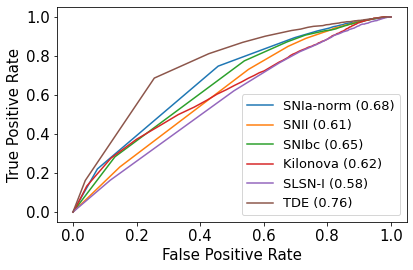

In [21]:
#@title  Make ROC curves with all test classes
font = {'family': 'normal', 'size': 15}
matplotlib.rc('font', **font)

anomaly_scoreslist_chi2_dict
model_classes = [1, 2, 3, 51, 60, 64]

test_classes = ['SNIa-norm', 'SNII', 'SNIbc', 'Kilonova', 'SLSN-I', 'TDE', 'CART', 'PISN', 'ILOT', 'uLens-BSR']

model_transient = 'SNIa-norm'
test_classes.remove(model_transient)
anomalous_transients =  test_classes  #['Kilonova', 'PISN', 'ILOT', 'uLens-BSR'] # 

tsteps = 1
for model_transient in model_classes:
    model_classname = sntypes_map[model_transient]
    print(model_classname)
    metric_names = ['$\chi^2$ without $\sigma_{pred}$', "negloglike with $\sigma_{pred}$", '$\chi^2$ with $\sigma_{pred}$', "negloglike without $\sigma_{pred}$"]
    for m, metric_dict in enumerate([anomaly_scoreslist_chi2_dict]):#, anomaly_scores_nll_wpredunc_dict, anomaly_score_chi2_wpredunc_dict, anomaly_score_nll_withoutpredunc_dict]):
        tprs = []
        fprs = []
        thresholds = []
        for threshold in np.append(np.arange(0, 3000, tsteps), np.inf):
            # if threshold % 100 == 0: print(model_transient, threshold)
            tp = np.count_nonzero(metric_dict[model_transient][model_classname] < threshold)
            fn = np.count_nonzero(metric_dict[model_transient][model_classname] > threshold)
            fp = sum([np.count_nonzero(metric_dict[model_transient][anomaly] < threshold) for anomaly in anomalous_transients])
            tn = sum([np.count_nonzero(metric_dict[model_transient][anomaly] > threshold) for anomaly in anomalous_transients])
            tpr = tp / (tp+fn)  # sensitivity
            fpr = fp / (fp+tn)  # 1 - specificity
        #     print(tp, fn, fp, tn, tpr, fpr)
            tprs.append(tpr)
            fprs.append(fpr)
            thresholds.append(threshold)

        auc = round(np.trapz(tprs, fprs), 3)
        plt.plot(fprs, tprs, label=f"{model_classname} ({auc:.2f})") # f"{metric_names[m]} ({auc})")

        # for i, threshold in enumerate(thresholds):
        #     if threshold % 10 == 0:
        #         plt.annotate(thresholds[i], # this is the text
        #                     (fprs[i],tprs[i]), # this is the point to label
        #                     textcoords="offset points", # how to position the text
        #                     xytext=(0,10), # distance from text to points (x,y)
        #                     ha='center') # horizontal alignment can be left, right or center

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig(f"DNN_ROC_curve_chi2_withalltestclasses_tstep{tsteps}_renamedtrueanomaly_scaleyperrby0point2.pdf")  # withanomalousclassesonly# plt.savefig(f"DNN_compare_metrics_onlyanomalousclasses_{model_classname}.pdf")
plt.show()

In [22]:
%%timeit
tp = sum(metric_dict[model_transient][model_classname] < threshold)
fn = sum(metric_dict[model_transient][model_classname] > threshold)
fp = sum([sum(metric_dict[model_transient][anomaly] < threshold) for anomaly in anomalous_transients])
tn = sum([sum(metric_dict[model_transient][anomaly] > threshold) for anomaly in anomalous_transients])
# tp = np.count_nonzero(metric_dict[model_transient][model_classname] < threshold)
# fn = np.count_nonzero(metric_dict[model_transient][model_classname] > threshold)
# fp = sum([np.count_nonzero(metric_dict[model_transient][anomaly] < threshold) for anomaly in anomalous_transients])
# tn = sum([np.count_nonzero(metric_dict[model_transient][anomaly] > threshold) for anomaly in anomalous_transients])

10 loops, best of 3: 90.5 ms per loop


SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE


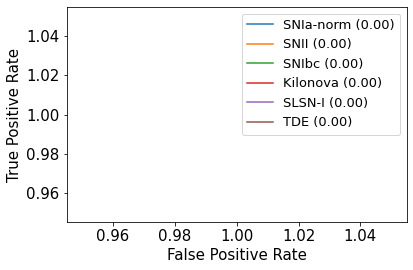

In [23]:
#@title Make ROC curves - with anomaly classes only
font = {'family': 'normal', 'size': 15}
matplotlib.rc('font', **font)

anomaly_scoreslist_chi2_dict
model_classes = [1, 2, 3, 51, 60, 64]

test_classes = ['SNIa-norm', 'SNII', 'SNIbc', 'Kilonova', 'SLSN-I', 'TDE', 'CART', 'PISN', 'ILOT', 'uLens-BSR']

model_transient = 'SNIa-norm'
test_classes.remove(model_transient)
anomalous_transients =  ['Kilonova', 'PISN', 'ILOT', 'uLens-BSR'] # test_classes  #['Kilonova', 'PISN', 'ILOT', 'uLens-BSR'] # 

tsteps = 0.1
for model_transient in model_classes:
    model_classname = sntypes_map[model_transient]
    print(model_classname)
    metric_names = ['$\chi^2$ without $\sigma_{pred}$', "negloglike with $\sigma_{pred}$", '$\chi^2$ with $\sigma_{pred}$', "negloglike without $\sigma_{pred}$"]
    for m, metric_dict in enumerate([anomaly_scoreslist_chi2_dict]):#, anomaly_scores_nll_wpredunc_dict, anomaly_score_chi2_wpredunc_dict, anomaly_score_nll_withoutpredunc_dict]):
        tprs = []
        fprs = []
        thresholds = []
        for threshold in np.append(np.arange(0, 3000, tsteps), np.inf):
            tp = np.count_nonzero(metric_dict[model_transient][model_classname] < threshold)
            fn = np.count_nonzero(metric_dict[model_transient][model_classname] > threshold)
            fp = sum([np.count_nonzero(metric_dict[model_transient][anomaly] < threshold) for anomaly in anomalous_transients])
            tn = sum([np.count_nonzero(metric_dict[model_transient][anomaly] > threshold) for anomaly in anomalous_transients])
 
        #     print(tp, fn, fp, tn, tpr, fpr)
            tprs.append(tpr)
            fprs.append(fpr)
            thresholds.append(threshold)

        auc = round(np.trapz(tprs, fprs), 3)
        plt.plot(fprs, tprs, label=f"{model_classname} ({auc:.2f})") # f"{metric_names[m]} ({auc})")

        # for i, threshold in enumerate(thresholds):
        #     if threshold % 10 == 0:
        #         plt.annotate(thresholds[i], # this is the text
        #                     (fprs[i],tprs[i]), # this is the point to label
        #                     textcoords="offset points", # how to position the text
        #                     xytext=(0,10), # distance from text to points (x,y)
        #                     ha='center') # horizontal alignment can be left, right or center

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig(f"DNN_ROC_curve_chi2_withanomalousclassesonly_tstep{tsteps}_renamedtrueanomaly_scaleyperrby0point2.pdf")  # withanomalousclassesonly# plt.savefig(f"DNN_compare_metrics_onlyanomalousclasses_{model_classname}.pdf")
plt.show()

Model: SNIa-norm
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR


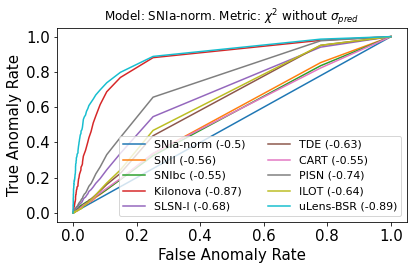

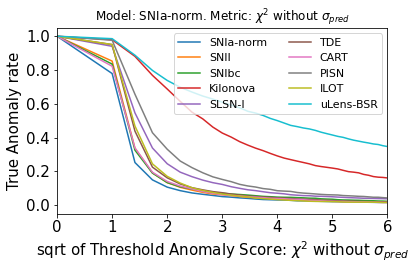

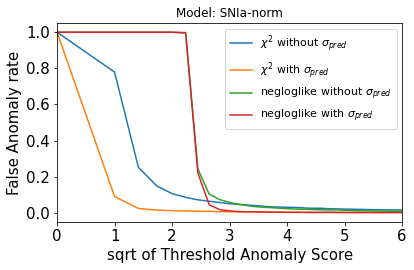

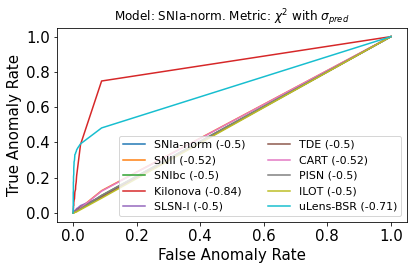

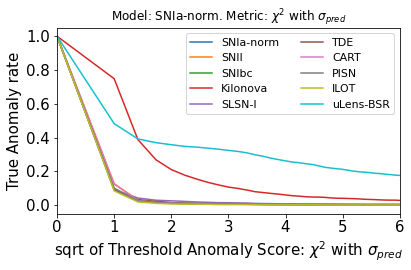

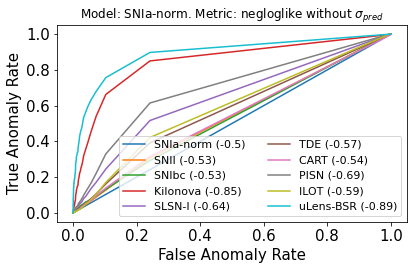

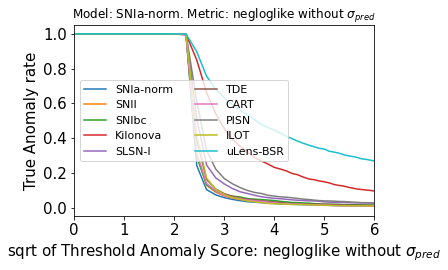

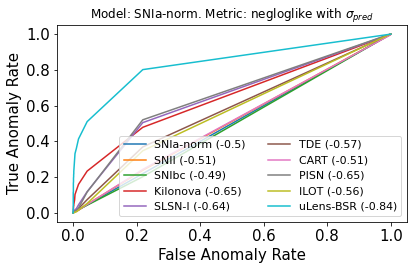

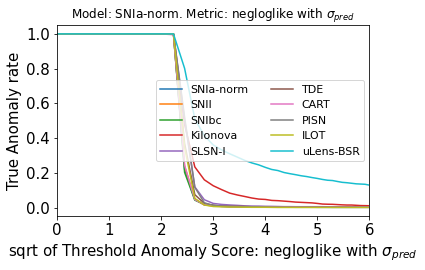

Model: SNII
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR


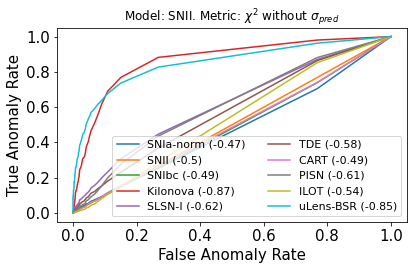

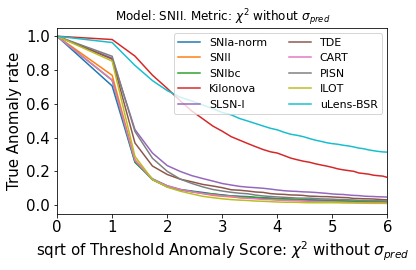

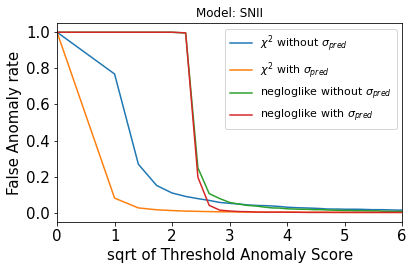

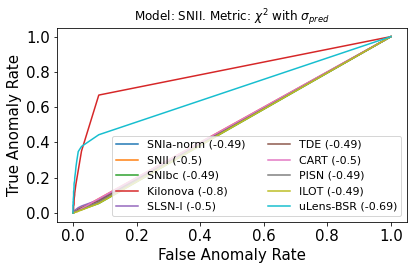

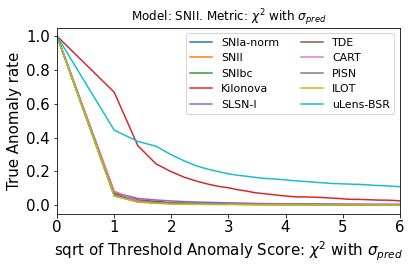

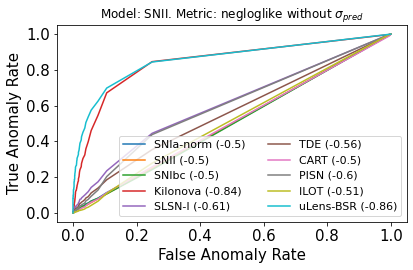

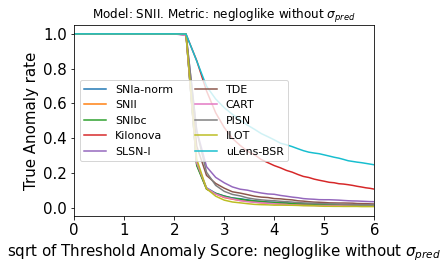

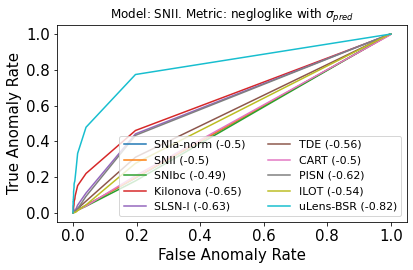

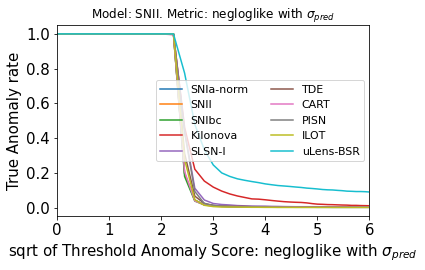

Model: SNIbc
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR


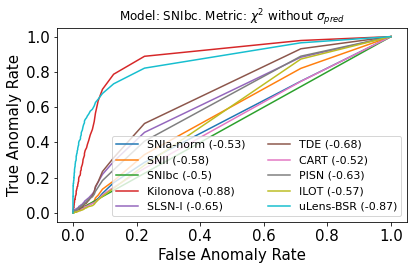

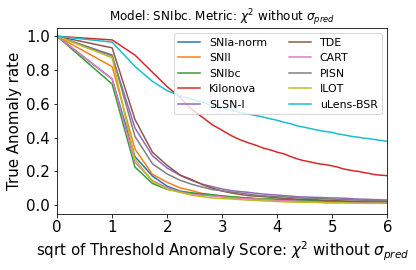

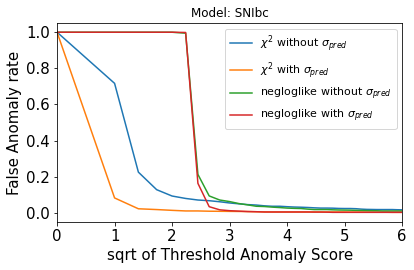

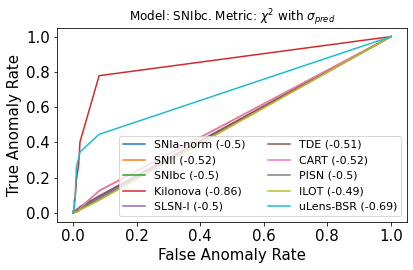

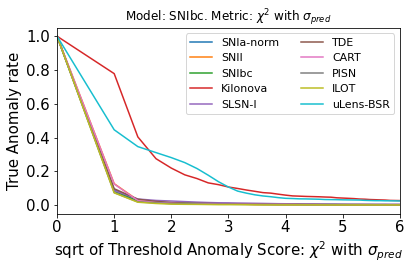

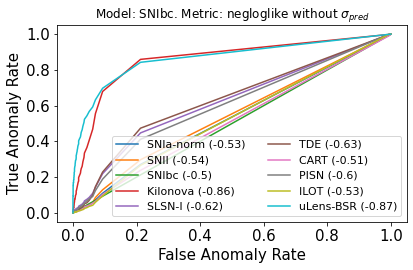

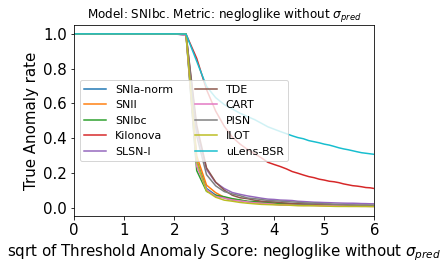

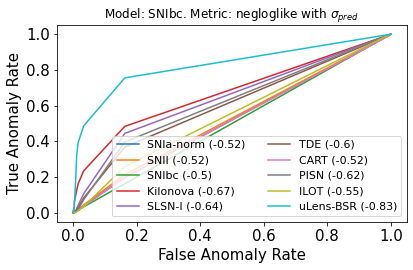

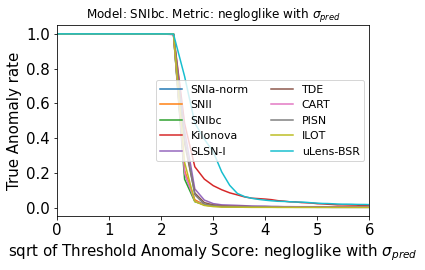

Model: Kilonova
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR


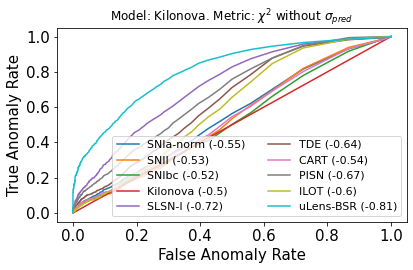

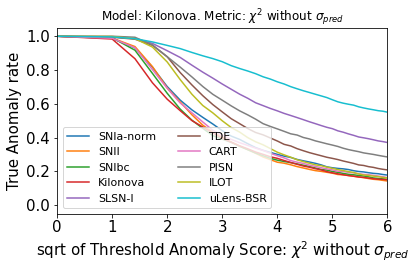

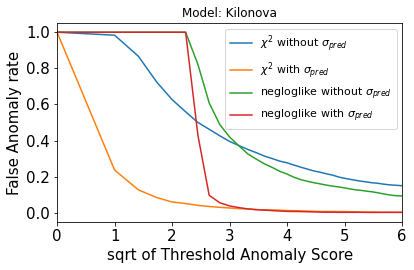

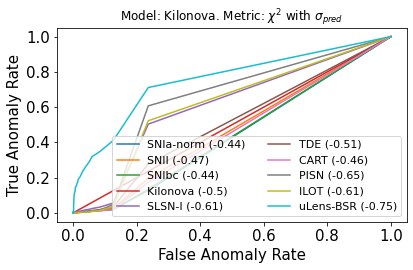

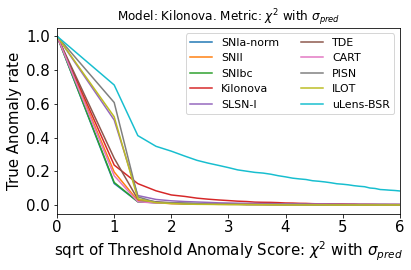

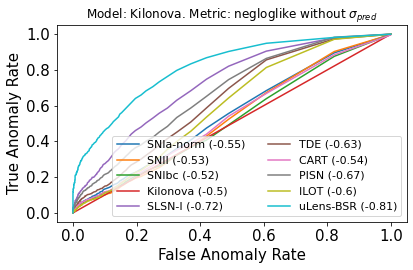

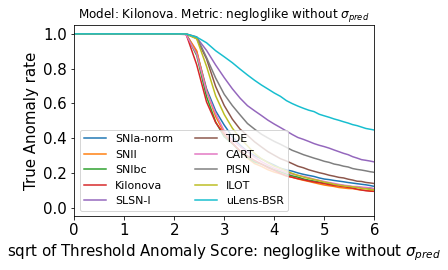

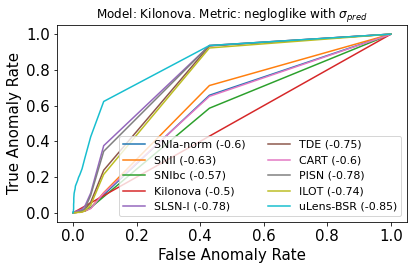

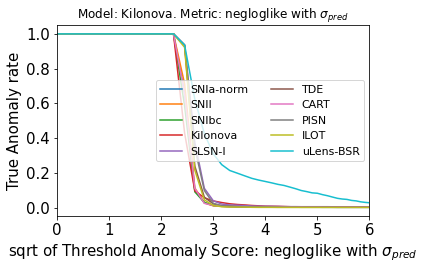

Model: SLSN-I
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR


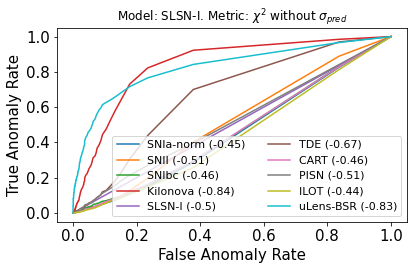

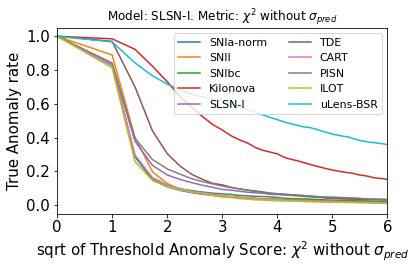

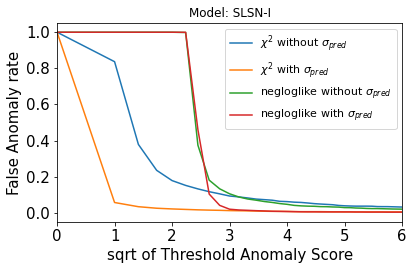

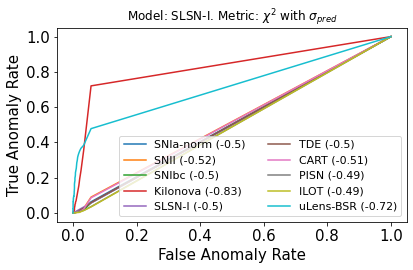

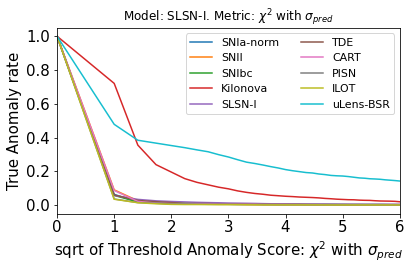

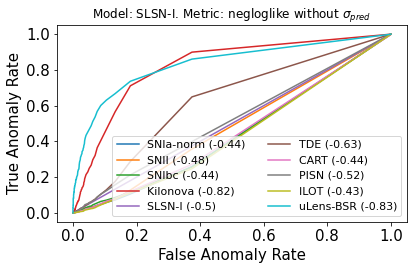

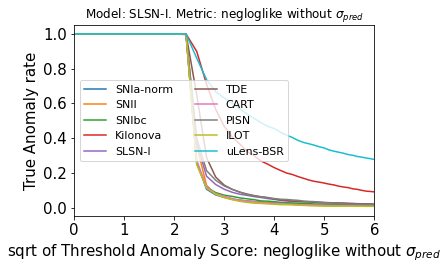

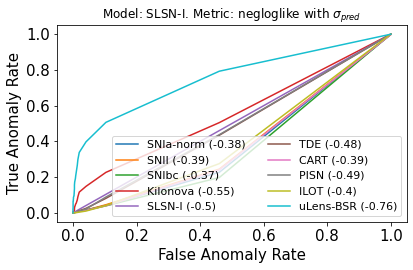

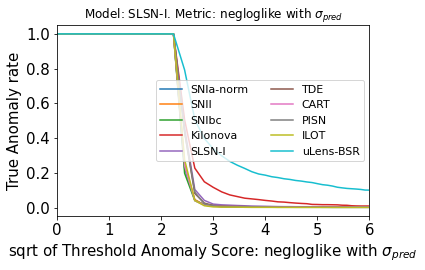

Model: TDE
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR
SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR


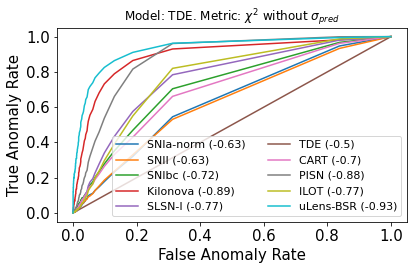

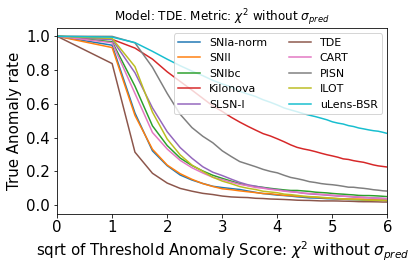

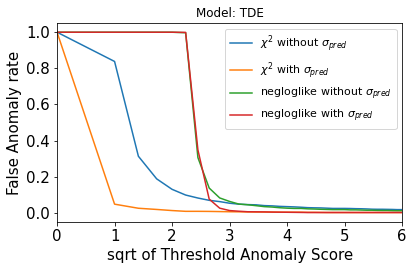

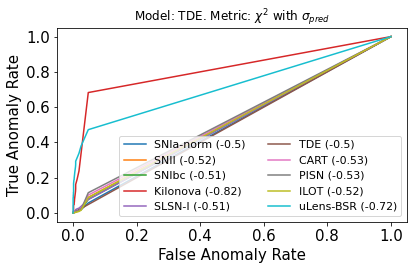

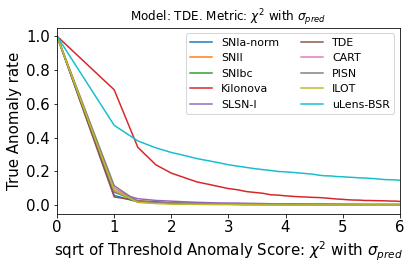

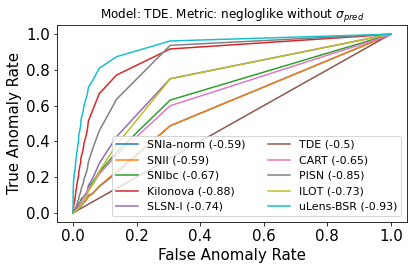

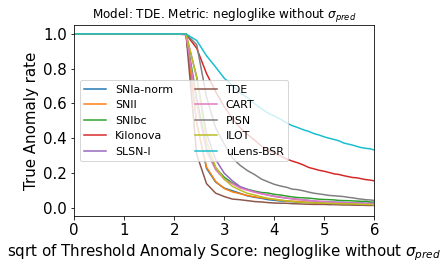

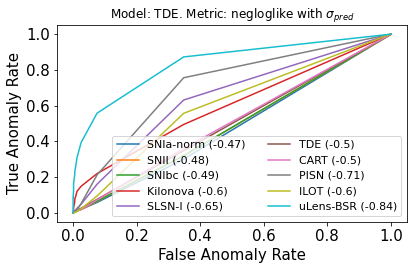

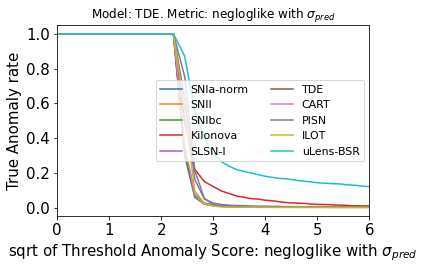

In [24]:
#@title Make ROC curves and threshold plots for all metric and all classes

font = {'family': 'normal', 'size': 15}
matplotlib.rc('font', **font)

model_classes = [1, 2, 3, 51, 60, 64]

class_colors = {'SNIa-norm': 'tab:blue', 'SNII': 'tab:orange', 'SNIbc': 'tab:green',
                'Kilonova': 'tab:red', 'SLSN-I': 'tab:purple', 'TDE': 'tab:brown', 
                'CART': 'tab:pink', 'PISN': 'tab:grey', 'ILOT': '#bcbd22', 'uLens-BSR': '#17becf'}

model_transient = 'SNIa-norm'


tsteps = 1
for model_transient in model_classes:
    model_classname = sntypes_map[model_transient]
    print("Model:", model_classname)
    test_classes = ['SNIa-norm', 'SNII', 'SNIbc', 'Kilonova', 'SLSN-I', 'TDE', 'CART', 'PISN', 'ILOT', 'uLens-BSR']
    # test_classes.remove(model_classname)

    metric_names = [r'$\chi^2$ without $\sigma_{pred}$', r'$\chi^2$ with $\sigma_{pred}$', r"negloglike without $\sigma_{pred}$", r"negloglike with $\sigma_{pred}$",]
    for m, metric_dict in enumerate([anomaly_scoreslist_chi2_dict, anomaly_score_chi2_wpredunc_dict, anomaly_score_nll_withoutpredunc_dict, anomaly_scores_nll_wpredunc_dict]):
        for anomaly in test_classes:
            print(anomaly)
            tars = []
            fars = []
            thresholds = []
            for threshold in np.append(np.arange(0, 3000, tsteps), np.inf):
                tna = np.count_nonzero(np.array(metric_dict[model_transient][model_classname]) < threshold)  # was tp. True not-anomaly
                fa = np.count_nonzero(np.array(metric_dict[model_transient][model_classname]) > threshold)  # was fn. False anomaly 
                fna = np.count_nonzero(np.array(metric_dict[model_transient][anomaly]) < threshold)  # was fp. False not-anomaly
                ta = np.count_nonzero(np.array(metric_dict[model_transient][anomaly]) > threshold)  # was tn. True anomaly 
                tar = ta / (ta+fna)  # sensitivity #tpr = tp / (tp+fn) --> tpr = tna/(tna+fa)
                far = fa / (fa+tna)  # 1 - specificity #fpr = fp / (fp+tn) --> fpr = fna/(fna+ta)
            #     print(tp, fn, fp, tn, tpr, fpr)
                tars.append(tar)
                fars.append(far)
                thresholds.append(threshold)
            
            fig1 = plt.figure(f"DNN_ROC_curve_chi2_{model_classname}vseachtestclass_tstep{tsteps}_renamedtrueanomaly_{metric_names[m]}")
            ax1 = plt.gca()
            auc = round(np.trapz(y=tars, x=fars), 2)
            ax1.plot(fars, tars, label=f"{anomaly} ({auc})", color=class_colors[anomaly])

            fig2 = plt.figure(f"DNN_threshold_vs_tar_curve_chi2_{model_classname}vseachtestclass_tstep{tsteps}_renamedtrueanomaly_{metric_names[m]}")
            ax2 = plt.gca()
            ax2.plot(np.sqrt(np.array(thresholds)), tars, label=f"{anomaly}", color=class_colors[anomaly])

            if anomaly == model_classname:  # FAR is the same for all "test classes", so just compute it once
                fig3 = plt.figure(f"DNN_threshold_vs_far_curve_chi2_{model_classname}_tstep{tsteps}_renamedtrueanomaly")
                ax3 = plt.gca()
                ax3.plot(np.sqrt(np.array(thresholds)), fars, label=f"{metric_names[m]}")

            # for i, threshold in enumerate(thresholds):
            #     if threshold in [1,2,3,4,5,6,7,8,9,10]:
            #         plt.annotate(int(thresholds[i]), # this is the text
            #                     (fars[i],tars[i]), # this is the point to label
            #                     textcoords="offset points", # how to position the text
            #                     xytext=(0,10), # distance from text to points (x,y)
            #                     ha='center') # horizontal alignment can be left, right or center

        ax1.set_title(f"Model: {model_classname}. Metric: {metric_names[m]}", fontsize=12)
        ax1.set_xlabel("False Anomaly Rate")
        ax1.set_ylabel("True Anomaly Rate")
        ax1.legend(fontsize=11, ncol=2, loc='lower right')
        fig1.tight_layout()
        fig1.savefig(f"DNN_ROC_curve_chi2_{model_classname}vseachtestclass_tstep{tsteps}_renamedtrueanomaly_{metric_names[m]}_scaleyperrby0point2.pdf")  #withanomalousclassesonly

        ax2.set_title(f"Model: {model_classname}. Metric: {metric_names[m]}", fontsize=12)
        ax2.set_xlabel(f"sqrt of Threshold Anomaly Score: {metric_names[m]}")
        ax2.set_ylabel("True Anomaly rate")
        ax2.legend(fontsize=11, ncol=2, loc='best')
        ax2.set_xlim(0,6)
        fig2.tight_layout()
        fig2.savefig(f"DNN_threshold_vs_tar_curve_chi2_{model_classname}vseachtestclass_tstep{tsteps}_renamedtrueanomaly_{metric_names[m]}_scaleyperrby0point2.pdf")

    ax3.set_title(f"Model: {model_classname}", fontsize=12)
    ax3.set_xlabel(f"sqrt of Threshold Anomaly Score")
    ax3.set_ylabel("False Anomaly rate")
    ax3.legend(fontsize=11, loc='best')
    ax3.set_xlim(0,6)
    fig3.tight_layout()
    fig3.savefig(f"DNN_threshold_vs_far_curve_chi2_{model_classname}vseachtestclass_tstep{tsteps}_renamedtrueanomaly_scaleyperrby0point2.pdf")

    plt.show()

In [ ]:
# Compare use of some scaling factor for sigma_pred
font = {'family': 'normal', 'size': 15}
matplotlib.rc('font', **font)

test_class_nums = [1, 2, 3, 51, 60, 64, 61, 62, 63, 90]#, 92]
preparearrays = PrepareTrainingSetArrays(passbands, contextual_info, data_dir, save_dir, training_set_dir, redo, get_data_func, use_gp_interp)
otherchange = 'linear_spline_with_unc_inXandy'#"using_only_goodobjectsw20datapoints"  # linear_spline_with_unc_inXandy
train_epochs = 10000 #2001 # 10000
nprocesses=None
extrapolate_gp=False
nsamples=1
ignore_class_names_test_on=[]
bayesian = True
sntypes_map = helpers.get_sntypes()

model_filepaths = {}
model_filepaths[1]  = f'plots/model_{otherchange}_ci()_ns1_c(1,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesian{bayesian}_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesian{bayesian}_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
# model_filepaths[2]  = f'plots/model_{otherchange}_ci()_ns1_c(2,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesian{bayesian}_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesian{bayesian}_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
# model_filepaths[3]  = f'plots/model_{otherchange}_ci()_ns1_c(3,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesian{bayesian}_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesian{bayesian}_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
# model_filepaths[51] = f'plots/model_{otherchange}_ci()_ns1_c(51,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesian{bayesian}_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesian{bayesian}_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
# model_filepaths[60] = f'plots/model_{otherchange}_ci()_ns1_c(60,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesian{bayesian}_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesian{bayesian}_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
# model_filepaths[64] = f'plots/model_{otherchange}_ci()_ns1_c(64,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesian{bayesian}_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesian{bayesian}_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'

anomaly_scoreslist_chi2_dict2 = {}
anomaly_scores_nll_wpredunc_dict2 = {}
anomaly_score_chi2_wpredunc_dict2 = {}
anomaly_score_nll_withoutpredunc_dict2 = {}
for model_class_num, model_filepath in model_filepaths.items():
    model_classname = sntypes_map[model_class_num]
    print(model_classname)
    
    # GET PREDICTIONS/DATA AND COMPUTE ANOMALY SCORES
    model = load_model(model_filepath, custom_objects={'loss': negloglike_with_error(), 'TCN': TCN})

    X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
    timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
        preparearrays.make_training_set(class_nums=test_class_nums, nsamples=1, otherchange='getKnAndOtherTypes', nprocesses=nprocesses, extrapolate_gp=extrapolate_gp, reframe=False, npred=1, normalise=normalise, use_uncertainties=use_uncertainties)

    # Get predictions
    nobjects, ntimesteps, nfeatures = y_test.shape
    npassbands = len(passbands)

    if bayesian:
        sampled_ypred = []
        sampled_ystd = []
        draws = []
        ns = 100
        for i in range(ns):
            sampled_yhat = model(X_test)
            sampled_ypred.append(np.asarray(sampled_yhat.mean()))
            sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
            draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
        y_pred_mean = np.mean(np.array(draws), axis=0)
        y_pred_sigma = np.std(np.array(draws), axis=0)
    else:
        yhat = model(X_test)
        y_pred_mean = np.asarray(yhat.mean())
        y_pred_sigma = np.asarray(yhat.stddev())

    class_nums = np.unique(labels_test)
    sntypes_map = helpers.get_sntypes()
    test_class_names = [sntypes_map[class_num] for class_num in class_nums]

    for sigpred_scalefactor in np.arange(0, 1.0001, 0.2):
        anomaly_scores_nll_withpredunc = {key: [] for key in test_class_names}
        anomaly_scores_chi2_withoutpredunc = {key: [] for key in test_class_names}
        anomaly_scores_chi2_withpredunc =  {key: [] for key in test_class_names}
        anomaly_scores_nll_withoutpredunc = {key: [] for key in test_class_names}
        for idx in range(nobjects):
            maskzeros = []
            npb = 0
            chi2 = 0
            negloglike = 0
            chi2_with_predunc = 0
            negloglike_without_predunc = 0
            maskzeros = True
            for pbidx in range(npassbands):
                yt = y_test[idx, :, pbidx]
                yterr = yerr_test[idx, :, pbidx]
                yp = y_pred_mean[idx, :, pbidx]
                yperr = y_pred_sigma[idx, :, pbidx] * sigpred_scalefactor
                maskzeros = ((yterr != 0) * (np.isfinite(yterr))) & maskzeros
                try:
                    chi2 += ((yp - yt)/yterr)**2
                    chi2_with_predunc += (yp - yt)**2 / (yterr**2 + yperr**2)
                    negloglike_without_predunc += 0.5 * (yp - yt)**2 / (yterr**2) + 0.5 *np.log(yterr**2) + 0.5*np.log(2*np.pi)
                    negloglike += 0.5 * (yp - yt)**2 / (yterr**2 + yperr**2) + 0.5 *np.log(yterr**2 + yperr**2) + 0.5*np.log(2*np.pi)
                    npb += 1
                except ValueError as e:
                    print(f"Failed chi2 object {objids_test[idx]}", e)
            if not np.any(maskzeros):
                continue
            chi2 = chi2[maskzeros] / npb
            negloglike = negloglike[maskzeros] / npb
            chi2_with_predunc = chi2_with_predunc[maskzeros] / npb
            negloglike_without_predunc = negloglike_without_predunc[maskzeros] / npb

            class_name = sntypes_map[labels_test[idx]]
            anomaly_scores_chi2_withoutpredunc[class_name].append(np.nanmean(chi2))
            anomaly_scores_chi2_withpredunc[class_name].append(np.nanmean(chi2_with_predunc))
            anomaly_scores_nll_withpredunc[class_name].append(np.nanmean(negloglike))
            anomaly_scores_nll_withoutpredunc[class_name].append(np.nanmean(negloglike_without_predunc))

        anomaly_scoreslist_chi2_dict2[model_classname] = anomaly_scores_chi2_withoutpredunc
        anomaly_scores_nll_wpredunc_dict2[model_classname] = anomaly_scores_nll_withpredunc
        anomaly_score_chi2_wpredunc_dict2[model_classname] = anomaly_scores_chi2_withpredunc
        anomaly_score_nll_withoutpredunc_dict2[model_classname] = anomaly_scores_nll_withoutpredunc

        # MAKE ROC CURVES
        print("Making ROC curves...")
        tsteps = 0.5
        anomalous_transients = ['SNIa-norm', 'SNII', 'SNIbc', 'Kilonova', 'SLSN-I', 'TDE', 'CART', 'PISN', 'ILOT', 'uLens-BSR']
        anomalous_transients.remove(model_classname)
        
        metric_names = [r'$\chi^2$', r"negloglike", ]
        for m, metric_dict in enumerate([anomaly_score_chi2_wpredunc_dict2, anomaly_scores_nll_wpredunc_dict2, ]):
            tars = []
            fars = []
            thresholds = []
            for threshold in np.append(np.arange(0, 3000, tsteps), np.inf):
                tna = np.count_nonzero(np.array(metric_dict[model_classname][model_classname]) < threshold)  # was tp. True not-anomaly
                fa = np.count_nonzero(np.array(metric_dict[model_classname][model_classname]) > threshold)  # was fn. False anomaly 
                fna = sum([np.count_nonzero(np.array(metric_dict[model_classname][anomaly]) < threshold) for anomaly in anomalous_transients])  # was fp. False not-anomaly
                ta = sum([np.count_nonzero(np.array(metric_dict[model_classname][anomaly]) > threshold) for anomaly in anomalous_transients])  # was tn. True anomaly 
                tar = ta / (ta+fna)  # sensitivity #tpr = tp / (tp+fn) --> tpr = tna/(tna+fa)
                far = fa / (fa+tna)  # 1 - specificity #fpr = fp / (fp+tn) --> fpr = fna/(fna+ta)
            #     print(tp, fn, fp, tn, tpr, fpr)
                tars.append(tar)
                fars.append(far)
                thresholds.append(threshold)
            
            fig1 = plt.figure(f"test_DNN_ROC_curve_chi2_{model_classname}vseachtestclass_tstep{tsteps}_renamedtrueanomaly_{metric_names[m]}")
            ax1 = plt.gca()
            auc = -round(np.trapz(y=tars, x=fars), 2)
            ax1.plot(fars, tars, label=f"{sigpred_scalefactor:.1f}$\sigma_{{pred}}$ ({auc})")#, color=class_colors[anomaly])

            fig2 = plt.figure(f"test_DNN_threshold_vs_tar_curve_chi2_{model_classname}vseachtestclass_tstep{tsteps}_renamedtrueanomaly_{metric_names[m]}")
            ax2 = plt.gca()
            ax2.plot(np.sqrt(np.array(thresholds)), tars, label=f"{sigpred_scalefactor:.1f}$\sigma_{{pred}}$)")# color=class_colors[anomaly])

            fig3 = plt.figure(f"test_DNN_threshold_vs_far_curve_chi2_{model_classname}_tstep{tsteps}_renamedtrueanomaly_{metric_names[m]}")
            ax3 = plt.gca()
            ax3.plot(np.sqrt(np.array(thresholds)), fars, label=f"{metric_names[m]} {sigpred_scalefactor:.1f}$\sigma_{{pred}}$")

            # for i, threshold in enumerate(thresholds):
            #     if threshold in [1,2,3,4,5,6,7,8,9,10]:
            #         plt.annotate(int(thresholds[i]), # this is the text
            #                     (fars[i],tars[i]), # this is the point to label
            #                     textcoords="offset points", # how to position the text
            #                     xytext=(0,10), # distance from text to points (x,y)
            #                     ha='center') # horizontal alignment can be left, right or center

            ax1.set_title(f"ROC curve. Model: {model_classname}. Metric: {metric_names[m]}", fontsize=12)
            ax1.set_xlabel("False Anomaly Rate")
            ax1.set_ylabel("True Anomaly Rate")
            ax1.legend(fontsize=11, ncol=2, loc='lower right')
            fig1.tight_layout()
            fig1.savefig(f"test_DNN_ROC_curve_chi2_{model_classname}vseachtestclass_tstep{tsteps}_renamedtrueanomaly_{metric_names[m]}.pdf")  #withanomalousclassesonly

            ax2.set_title(f"TAR vs thresh. Model: {model_classname}. Metric: {metric_names[m]}", fontsize=12)
            ax2.set_xlabel(f"sqrt of Threshold Anomaly Score: {metric_names[m]}")
            ax2.set_ylabel("True Anomaly rate")
            ax2.legend(fontsize=11, ncol=2, loc='best')
            ax2.set_xlim(0,6)
            fig2.tight_layout()
            fig2.savefig(f"test_DNN_threshold_vs_tar_curve_chi2_{model_classname}vseachtestclass_tstep{tsteps}_renamedtrueanomaly_{metric_names[m]}.pdf")

            ax3.set_title(f"FAR vs thresh. Model: {model_classname}", fontsize=12)
            ax3.set_xlabel(f"sqrt of Threshold Anomaly Score")
            ax3.set_ylabel("False Anomaly rate")
            ax3.legend(fontsize=11, ncol=2, loc='best')
            ax3.set_xlim(0,6)
            fig3.tight_layout()
            fig3.savefig(f"test_DNN_threshold_vs_far_curve_chi2_{model_classname}vseachtestclass_tstep{tsteps}_renamedtrueanomaly_{metric_names[m]}.pdf")

    plt.show()


SNIa-norm


In [ ]:

print(((yp - yt)/yterr)**2)

print((yp - yt)**2 / (yterr**2 + 0*yperr**2))

In [ ]:
len(anomaly_scores_chi2['SNIa-norm'])

In [ ]:
# Check anomlay score claculaton is consisten with one in Similariy scores function distribution matches previous
x1 = np.array(anomaly_scoreslist_chi2_dict[1]['SNIa-norm'])
x2 = np.array(anomaly_scoreslist_chi2_dict2['SNIa-norm']['SNIa-norm'])
plt.hist(x1[x1<10], bins=100, alpha=0.5)
plt.hist(x2[x2<10], bins=100, alpha=0.5)
plt.show()

In [ ]:
left! ls plots/'model_linear_spline_with_unc_inXandy_ci()_ns1_c(1,)'/'keras_model_epochs5000_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001'/'keras_model_epochs5000_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5
'


In [ ]:
for i in range(len(X_train[0])):
  print(X_test[0][i], y_test[0][i])

In [ ]:
light_curves = {}
gp_fits = {}
for classnum in np.unique(labels_test):
    print(f"Getting lightcurves for class:{classnum}")
    light_curves[classnum] = get_data(get_data_func=get_data_func, class_num=classnum, data_dir=data_dir,
                                      save_dir=save_dir, passbands=passbands, known_redshift=known_redshift,
                                      nprocesses=nprocesses, redo=False, calculate_t0=False)
gp_fits[classnum] = save_gps(light_curves, save_dir, classnum, passbands, plot=False,
                          nprocesses=nprocesses, redo=False, extrapolate=extrapolate_gp)

In [ ]:
# yhat = model(X_train[0:1])
# y_pred = np.asarray(yhat.mean())
# y_pred_std = np.asarray(yhat.stddev())
# print(X_train[0], y_pred)
print(X_train.shape)

In [ ]:
# loss=lambda y, rv_y: -rv_y.log_prob(y)
# model.set_weights(old_weights)
model.compile(loss=negloglike_with_error(), optimizer='adam')
model.evaluate(X_test, y_test)
# Default model

In [ ]:
! git config --global user.email "daniel.muthukrishna@gmail.com"
! git config --global user.name "daniel-muthukrishna"
# ! git diff
! git stash
! git pull

In [ ]:
# # not-Bayesian:
# Model: "sequential_1"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# masking_1 (Masking)          (None, 49, 2)             0         
# _________________________________________________________________
# matching_conv1D (Conv1D)     (None, 49, 30)            90        
# _________________________________________________________________
# activation_14 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            150       
# _________________________________________________________________
# activation_12 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_8 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_13 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_9 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_17 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_15 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_10 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_16 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_11 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_20 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_18 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_12 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_19 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_13 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_23 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_21 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_14 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_22 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_15 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# lambda_1 (Lambda)            multiple                  0         
# _________________________________________________________________
# time_distributed_1 (TimeDist (None, 49, 4)             124       
# _________________________________________________________________
# distribution_lambda_1 (Distr ((None, 49, 2), (None, 49 0         
# =================================================================
# Total params: 13,174
# Trainable params: 13,174
# Non-trainable params: 0

# # Bayesian network:
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# masking_3 (Masking)          (None, 49, 2)             0         
# _________________________________________________________________
# matching_conv1D (Conv1DFlipo (None, 49, 30)            150       
# _________________________________________________________________
# activation_14 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            270       
# _________________________________________________________________
# activation_12 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_8 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_13 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_9 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_17 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_15 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_10 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_16 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_11 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_20 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_18 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_12 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_19 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_13 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_23 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_21 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_14 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_22 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_15 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# lambda_1 (Lambda)            multiple                  0         
# _________________________________________________________________
# time_distributed_3 (TimeDist (None, 49, 4)             244       
# _________________________________________________________________
# distribution_lambda_3 (Distr ((None, 49, 2), (None, 49 0         
# =================================================================
# Total params: 26,074
# Trainable params: 26,074
# Non-trainable params: 0

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()